In [71]:
#Import the necessary pacakges 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

In [72]:
##A function to download the stock price data. 
SYMBOLS = ["AAPL", "MSFT", "AMZN", "META", "GOOGL", "GOOG", "BRK-B", "TSLA", "NVDA", "JPM"]
def format_dataset():
    all_stocks_data = []
    prices = yf.download(SYMBOLS, start=START, end=END)
    for symbol in SYMBOLS:
        prices.index = prices.index.map(str)
        stock_df = prices.T.loc[(slice(None), symbol), :].swaplevel(i=0, j=1).xs(symbol, level=0).T.dropna(how="all")
        stock_df["symbol"] = symbol
        stock_df["date"] = pd.to_datetime(stock_df.index)
        stock_df["price"] = stock_df["Adj Close"]
        all_stocks_data.append(stock_df[["symbol", "date", "price"]].reset_index(drop=True))
    combined = pd.concat(all_stocks_data)
    combined.to_csv("data.csv")

In [73]:
##Create the LSTM model
class LSTM(nn.Module):
    def __init__(self, hidden_size, num_layers, out_seq):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.out_seq = out_seq
        #Define the LSTM model
        self.LSTM = nn.LSTM(
            input_size=1,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )
        
        #Define the Linear model to get the ouput. 
        self.linear = nn.Linear(self.hidden_size, self.out_seq)
        
        #Define the forward function 
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device = x.device).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device = x.device).requires_grad_()
        # Perform LSTM model. 
        out, (hn, cn) = self.LSTM(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> batch size, sequence_length, hidden_size
        # out[:, -1, :] --> batch size, 1, hidden_size --> We only need the hidden size of the last time. 
        out = self.linear(out[:, -1, :]) 
        return out

    
    

In [122]:
##Create a file to automatically load dataset and separate the data into train_data and test_data

#Load the datasets.
def load_data(stock_ID, look_back_days):
    dat = pd.read_csv('data.csv')
    price=dat.loc[dat['symbol']== stock_ID]
    price=price.set_index('date')
    price=price.drop(['symbol'], axis=1)
    price['price'] = scaler.fit_transform(price['price'].values.reshape(-1,1))
    #print(price)
    time_cutoff = "2022/9/30"
    time_final = "2022/11/18"
    time_cutoff_loc = price.index.get_loc(time_cutoff)
    time_final_loc = price.index.get_loc(time_final)
    
    #Get the days for prediction
    pred_days = price.index[(time_cutoff_loc + 1):(time_final_loc + 1)].to_numpy()
    N_pred_days = len(pred_days)

    #Split the data into train and test. 
    train_price=price['price'].iloc[:(time_cutoff_loc + 1)]
    test_price = price['price'].iloc[(time_cutoff_loc - look_back_days + 1):(time_final_loc + 1)]

    
    ##Get the x_train and y_train dataset
    x_train = []
    y_train = []
    for index in range(len(train_price) - look_back_days - N_pred_days): 
        x_train.append(train_price.iloc[index:index + look_back_days].to_numpy())
        y_train.append(train_price.iloc[(index + look_back_days):(index + look_back_days + N_pred_days)].to_numpy())
        
    x_train = torch.FloatTensor(np.array(x_train))
    y_train = torch.FloatTensor(np.array(y_train))
    x_train = torch.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    #y_train = torch.reshape(y_train, (y_train.shape[0], y_train.shape[1]))

    ##Get the x_test and y_test dataset
    x_test = torch.FloatTensor(price['price'].iloc[(time_cutoff_loc - look_back_days + 1):(time_cutoff_loc + 1)])
    y_test = torch.FloatTensor(price['price'].iloc[(time_cutoff_loc + 1):])
    x_test = torch.reshape(x_test, (1, x_test.shape[0],1))
    y_test = torch.reshape(y_test, (1, y_test.shape[0]))
    ##combine the x,y into a complete dataset.

    train_dat = Data.TensorDataset(x_train, y_train)
    test_dat = Data.TensorDataset(x_test, y_test)

    
    return train_dat, test_dat, pred_days

In [123]:
##Define a train function to train the model. 
def model_perf(train_dat, test_dat, N_pred_days, pred_days, hidden_size, num_layers, learning_rate, look_back_days, batch_size, epoches = 20):

    ## Select the device
    model = LSTM(hidden_size, num_layers, N_pred_days)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        model.cuda()
    
    ## Define the loss function and optimizer. 
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate) # Another hyperparameter.


    #Split the train dataset into training (80%) and validation (20%). 
    train_Nsamples = int(len(train_dat) * 0.8)
    
    train_subset, val_subset = Data.random_split(
        train_dat, [train_Nsamples, len(train_dat) - train_Nsamples])

    trainloader = Data.DataLoader(
        train_subset,
        batch_size=batch_size,       # Another hyperparameter
        shuffle=True,
        num_workers=8)
    
    valloader = Data.DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8)
            
    for epoch in range(epoches):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0

        # For loop to train the model.
        for batch_x, batch_y in trainloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss = loss.item()

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        for batch_x, batch_y in valloader:
            with torch.no_grad():
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = loss_fn(outputs, batch_y)
                val_loss += loss.cpu().numpy()
                val_steps += 1
                
        ##Output the performance for each epoch. 
        print("Epoch: %d, Training loss: %.3f, Validation loss: %.3f" % (epoch + 1, running_loss, val_loss/val_steps))
    
    # Test loss 
    testloader = Data.DataLoader(
        test_dat, batch_size=len(test_dat), shuffle=False, num_workers=1)
    


    #Perform the analysis with all test data. 
    with torch.no_grad():
        for batch_x, batch_y in testloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            
            y_test_pred = scaler.inverse_transform(outputs.detach().cpu().numpy()).flatten()
            y_test = scaler.inverse_transform(batch_y.detach().cpu().numpy()).flatten()
            #print("The true stock prices are: ", y_test)
            #print("The predicted stock prices are: ", y_test_pred)
            RMSE = math.sqrt(mean_squared_error(y_test, y_test_pred))
            MSE = mean_squared_error(y_test,y_test_pred)
            print('Test RMSE: %.4f, MSE: %.4f' % (RMSE, MSE))
    
    ##Create a dataframe for visualization.
    df = pd.DataFrame({"pred_days":pred_days, "True_price": y_test, "Pred_price":y_test_pred}, index = pred_days)
            
    return df, RMSE, MSE, running_loss, val_loss/val_steps


In [125]:
##Define the hyperparamters.
hidden_size = [128, 192, 256]
n_layers = [2,3]
learning_rate = [0.008, 0.01]
lb_days = [5, 10, 15, 30]
bs = 32
ep = 20
SPY_TOP_10_SYMBOLS = ["AAPL", "MSFT", "AMZN", "META", "GOOGL", "GOOG", "BRK-B", "TSLA", "NVDA", "JPM"]


df_total = []
df_SYMBOL=[]
df_HS = []
df_LAYER = []
df_LR = []
df_LD = []

SYMBOL = []
HS = []
LAYER = []
LR = []
LD = []
RMSE_total = []
MSE_total = []
TRAIN_LOSS_total = []
VAL_LOSS_total = []
i = 0
print("Start")
for symbol in SPY_TOP_10_SYMBOLS:
    for ld in lb_days:
        train_dat, test_dat, pred_days = load_data(symbol, ld)  #Load the dataset. 
        for hs in hidden_size:
            for nl in n_layers:
                for lr in learning_rate:
                    df, RMSE, MSE,Train_Loss, Val_Loss = model_perf(train_dat, test_dat, len(pred_days), pred_days, hidden_size = hs, num_layers = nl, learning_rate = lr,
                                               look_back_days = ld, batch_size = bs, epoches= ep)
                    #Adding df data
                    df_len = df.shape[0]
                    df_total.extend(df['Pred_price'].to_numpy())
                    df_SYMBOL.extend([symbol]*df_len)
                    df_HS.extend([hs]*df_len)
                    df_LAYER.extend([nl]*df_len)
                    df_LR.extend([lr]*df_len)
                    df_LD.extend([ld]*df_len)
                    
                    RMSE_total.append(RMSE)
                    MSE_total.append(MSE)
                    SYMBOL.append(symbol)
                    HS.append(hs)
                    LAYER.append(nl)
                    LR.append(lr)
                    LD.append(ld)
                    TRAIN_LOSS_total.append(Train_Loss)
                    VAL_LOSS_total.append(Val_Loss)
                    
                    #Echo
                    print('Round %d of 480. Test RMSE: %.4f, MSE: %.4f' % (i + 1, RMSE, MSE))
                    i += 1

                    
##File 1:
df_data = pd.DataFrame({"Pred_price":df_total, "SYMBOL": df_SYMBOL, "HS": df_HS, "LAYER": df_LAYER, "LR": df_LR, "LD": df_LD})
df_data.to_excel("df_data2.xlsx")
##File 2:
df_result = pd.DataFrame({"SYMBOL":SYMBOL, "HS": HS, "LAYER":LAYER, "LR":LR, "LD":LD, "RMSE":RMSE_total, "MSE":MSE_total, 
                          "TRAIN_LOSS": TRAIN_LOSS_total, "VAL_LOSS":VAL_LOSS_total})
df_result.to_excel("df_result2.xlsx")

                    


Start
Epoch: 1, Training loss: 0.194, Validation loss: 0.192
Epoch: 2, Training loss: 0.229, Validation loss: 0.186
Epoch: 3, Training loss: 0.273, Validation loss: 0.196
Epoch: 4, Training loss: 0.249, Validation loss: 0.186
Epoch: 5, Training loss: 0.245, Validation loss: 0.186
Epoch: 6, Training loss: 0.199, Validation loss: 0.189
Epoch: 7, Training loss: 0.221, Validation loss: 0.175
Epoch: 8, Training loss: 0.167, Validation loss: 0.169
Epoch: 9, Training loss: 0.146, Validation loss: 0.185
Epoch: 10, Training loss: 0.132, Validation loss: 0.182
Epoch: 11, Training loss: 0.213, Validation loss: 0.181
Epoch: 12, Training loss: 0.219, Validation loss: 0.171
Epoch: 13, Training loss: 0.186, Validation loss: 0.172
Epoch: 14, Training loss: 0.181, Validation loss: 0.180
Epoch: 15, Training loss: 0.222, Validation loss: 0.160
Epoch: 16, Training loss: 0.210, Validation loss: 0.158
Epoch: 17, Training loss: 0.130, Validation loss: 0.164
Epoch: 18, Training loss: 0.238, Validation loss: 0

Epoch: 20, Training loss: 0.204, Validation loss: 0.206
Test RMSE: 4.8852, MSE: 23.8656
Round 7 of 480. Test RMSE: 4.8852, MSE: 23.8656
Epoch: 1, Training loss: 0.352, Validation loss: 0.232
Epoch: 2, Training loss: 0.309, Validation loss: 0.237
Epoch: 3, Training loss: 0.207, Validation loss: 0.294
Epoch: 4, Training loss: 0.195, Validation loss: 0.226
Epoch: 5, Training loss: 0.227, Validation loss: 0.209
Epoch: 6, Training loss: 0.237, Validation loss: 0.219
Epoch: 7, Training loss: 0.213, Validation loss: 0.209
Epoch: 8, Training loss: 0.225, Validation loss: 0.205
Epoch: 9, Training loss: 0.290, Validation loss: 0.202
Epoch: 10, Training loss: 0.209, Validation loss: 0.204
Epoch: 11, Training loss: 0.214, Validation loss: 0.215
Epoch: 12, Training loss: 0.149, Validation loss: 0.207
Epoch: 13, Training loss: 0.191, Validation loss: 0.239
Epoch: 14, Training loss: 0.193, Validation loss: 0.209
Epoch: 15, Training loss: 0.203, Validation loss: 0.215
Epoch: 16, Training loss: 0.199, 

Epoch: 18, Training loss: 0.292, Validation loss: 0.192
Epoch: 19, Training loss: 0.109, Validation loss: 0.187
Epoch: 20, Training loss: 0.121, Validation loss: 0.196
Test RMSE: 5.0175, MSE: 25.1753
Round 14 of 480. Test RMSE: 5.0175, MSE: 25.1753
Epoch: 1, Training loss: 0.201, Validation loss: 0.266
Epoch: 2, Training loss: 0.143, Validation loss: 0.297
Epoch: 3, Training loss: 0.191, Validation loss: 0.247
Epoch: 4, Training loss: 0.179, Validation loss: 0.228
Epoch: 5, Training loss: 0.298, Validation loss: 0.249
Epoch: 6, Training loss: 0.186, Validation loss: 0.224
Epoch: 7, Training loss: 0.282, Validation loss: 0.219
Epoch: 8, Training loss: 0.262, Validation loss: 0.195
Epoch: 9, Training loss: 0.299, Validation loss: 0.191
Epoch: 10, Training loss: 0.236, Validation loss: 0.195
Epoch: 11, Training loss: 0.141, Validation loss: 0.189
Epoch: 12, Training loss: 0.315, Validation loss: 0.186
Epoch: 13, Training loss: 0.176, Validation loss: 0.187
Epoch: 14, Training loss: 0.183,

Epoch: 16, Training loss: 0.231, Validation loss: 0.197
Epoch: 17, Training loss: 0.163, Validation loss: 0.207
Epoch: 18, Training loss: 0.228, Validation loss: 0.206
Epoch: 19, Training loss: 0.131, Validation loss: 0.201
Epoch: 20, Training loss: 0.064, Validation loss: 0.204
Test RMSE: 6.9850, MSE: 48.7909
Round 21 of 480. Test RMSE: 6.9850, MSE: 48.7909
Epoch: 1, Training loss: 0.141, Validation loss: 0.574
Epoch: 2, Training loss: 0.363, Validation loss: 0.237
Epoch: 3, Training loss: 0.290, Validation loss: 0.236
Epoch: 4, Training loss: 0.201, Validation loss: 0.201
Epoch: 5, Training loss: 0.292, Validation loss: 0.196
Epoch: 6, Training loss: 0.279, Validation loss: 0.199
Epoch: 7, Training loss: 0.239, Validation loss: 0.256
Epoch: 8, Training loss: 0.216, Validation loss: 0.201
Epoch: 9, Training loss: 0.144, Validation loss: 0.214
Epoch: 10, Training loss: 0.195, Validation loss: 0.204
Epoch: 11, Training loss: 0.390, Validation loss: 0.214
Epoch: 12, Training loss: 0.292,

Epoch: 14, Training loss: 0.157, Validation loss: 0.183
Epoch: 15, Training loss: 0.166, Validation loss: 0.160
Epoch: 16, Training loss: 0.127, Validation loss: 0.155
Epoch: 17, Training loss: 0.181, Validation loss: 0.171
Epoch: 18, Training loss: 0.160, Validation loss: 0.176
Epoch: 19, Training loss: 0.141, Validation loss: 0.174
Epoch: 20, Training loss: 0.117, Validation loss: 0.178
Test RMSE: 12.4789, MSE: 155.7229
Round 28 of 480. Test RMSE: 12.4789, MSE: 155.7229
Epoch: 1, Training loss: 0.243, Validation loss: 0.320
Epoch: 2, Training loss: 0.266, Validation loss: 0.251
Epoch: 3, Training loss: 0.276, Validation loss: 0.245
Epoch: 4, Training loss: 0.241, Validation loss: 0.216
Epoch: 5, Training loss: 0.218, Validation loss: 0.208
Epoch: 6, Training loss: 0.193, Validation loss: 0.210
Epoch: 7, Training loss: 0.187, Validation loss: 0.194
Epoch: 8, Training loss: 0.204, Validation loss: 0.188
Epoch: 9, Training loss: 0.178, Validation loss: 0.182
Epoch: 10, Training loss: 0.

Epoch: 12, Training loss: 0.171, Validation loss: 0.226
Epoch: 13, Training loss: 0.193, Validation loss: 0.218
Epoch: 14, Training loss: 0.172, Validation loss: 0.210
Epoch: 15, Training loss: 0.184, Validation loss: 0.209
Epoch: 16, Training loss: 0.177, Validation loss: 0.207
Epoch: 17, Training loss: 0.151, Validation loss: 0.189
Epoch: 18, Training loss: 0.190, Validation loss: 0.233
Epoch: 19, Training loss: 0.172, Validation loss: 0.210
Epoch: 20, Training loss: 0.188, Validation loss: 0.248
Test RMSE: 5.4845, MSE: 30.0798
Round 35 of 480. Test RMSE: 5.4845, MSE: 30.0798
Epoch: 1, Training loss: 0.272, Validation loss: 0.283
Epoch: 2, Training loss: 0.279, Validation loss: 0.526
Epoch: 3, Training loss: 0.274, Validation loss: 10.874
Epoch: 4, Training loss: 0.236, Validation loss: 0.223
Epoch: 5, Training loss: 0.236, Validation loss: 0.265
Epoch: 6, Training loss: 0.353, Validation loss: 0.605
Epoch: 7, Training loss: 0.418, Validation loss: 0.271
Epoch: 8, Training loss: 0.28

Epoch: 10, Training loss: 0.116, Validation loss: 0.142
Epoch: 11, Training loss: 0.164, Validation loss: 0.149
Epoch: 12, Training loss: 0.129, Validation loss: 0.170
Epoch: 13, Training loss: 0.105, Validation loss: 0.176
Epoch: 14, Training loss: 0.145, Validation loss: 0.178
Epoch: 15, Training loss: 0.174, Validation loss: 0.175
Epoch: 16, Training loss: 0.149, Validation loss: 0.168
Epoch: 17, Training loss: 0.124, Validation loss: 0.171
Epoch: 18, Training loss: 0.119, Validation loss: 0.139
Epoch: 19, Training loss: 0.187, Validation loss: 0.179
Epoch: 20, Training loss: 0.113, Validation loss: 0.173
Test RMSE: 10.0104, MSE: 100.2084
Round 42 of 480. Test RMSE: 10.0104, MSE: 100.2084
Epoch: 1, Training loss: 0.246, Validation loss: 0.648
Epoch: 2, Training loss: 0.252, Validation loss: 0.224
Epoch: 3, Training loss: 0.317, Validation loss: 0.225
Epoch: 4, Training loss: 0.242, Validation loss: 0.240
Epoch: 5, Training loss: 0.217, Validation loss: 0.215
Epoch: 6, Training loss:

Epoch: 8, Training loss: 0.119, Validation loss: 0.096
Epoch: 9, Training loss: 0.091, Validation loss: 0.097
Epoch: 10, Training loss: 0.118, Validation loss: 0.086
Epoch: 11, Training loss: 0.075, Validation loss: 0.082
Epoch: 12, Training loss: 0.090, Validation loss: 0.087
Epoch: 13, Training loss: 0.083, Validation loss: 0.077
Epoch: 14, Training loss: 0.094, Validation loss: 0.073
Epoch: 15, Training loss: 0.091, Validation loss: 0.078
Epoch: 16, Training loss: 0.106, Validation loss: 0.084
Epoch: 17, Training loss: 0.095, Validation loss: 0.070
Epoch: 18, Training loss: 0.066, Validation loss: 0.088
Epoch: 19, Training loss: 0.084, Validation loss: 0.070
Epoch: 20, Training loss: 0.063, Validation loss: 0.071
Test RMSE: 34.9402, MSE: 1220.8203
Round 49 of 480. Test RMSE: 34.9402, MSE: 1220.8203
Epoch: 1, Training loss: 0.110, Validation loss: 0.155
Epoch: 2, Training loss: 0.095, Validation loss: 0.116
Epoch: 3, Training loss: 0.120, Validation loss: 0.098
Epoch: 4, Training los

Epoch: 5, Training loss: 0.123, Validation loss: 0.102
Epoch: 6, Training loss: 0.068, Validation loss: 0.091
Epoch: 7, Training loss: 0.112, Validation loss: 0.096
Epoch: 8, Training loss: 0.076, Validation loss: 0.089
Epoch: 9, Training loss: 0.094, Validation loss: 0.082
Epoch: 10, Training loss: 0.095, Validation loss: 0.082
Epoch: 11, Training loss: 0.072, Validation loss: 0.083
Epoch: 12, Training loss: 0.077, Validation loss: 0.077
Epoch: 13, Training loss: 0.079, Validation loss: 0.078
Epoch: 14, Training loss: 0.107, Validation loss: 0.081
Epoch: 15, Training loss: 0.063, Validation loss: 0.075
Epoch: 16, Training loss: 0.067, Validation loss: 0.076
Epoch: 17, Training loss: 0.073, Validation loss: 0.078
Epoch: 18, Training loss: 0.090, Validation loss: 0.080
Epoch: 19, Training loss: 0.073, Validation loss: 0.081
Epoch: 20, Training loss: 0.067, Validation loss: 0.079
Test RMSE: 34.6047, MSE: 1197.4851
Round 56 of 480. Test RMSE: 34.6047, MSE: 1197.4851
Epoch: 1, Training los

Epoch: 2, Training loss: 0.090, Validation loss: 0.159
Epoch: 3, Training loss: 0.198, Validation loss: 0.216
Epoch: 4, Training loss: 0.189, Validation loss: 0.134
Epoch: 5, Training loss: 0.123, Validation loss: 0.129
Epoch: 6, Training loss: 0.100, Validation loss: 0.114
Epoch: 7, Training loss: 0.102, Validation loss: 0.098
Epoch: 8, Training loss: 0.081, Validation loss: 0.094
Epoch: 9, Training loss: 0.105, Validation loss: 0.099
Epoch: 10, Training loss: 0.069, Validation loss: 0.097
Epoch: 11, Training loss: 0.097, Validation loss: 0.093
Epoch: 12, Training loss: 0.074, Validation loss: 0.099
Epoch: 13, Training loss: 0.083, Validation loss: 0.091
Epoch: 14, Training loss: 0.072, Validation loss: 0.082
Epoch: 15, Training loss: 0.059, Validation loss: 0.091
Epoch: 16, Training loss: 0.059, Validation loss: 0.082
Epoch: 17, Training loss: 0.066, Validation loss: 0.087
Epoch: 18, Training loss: 0.075, Validation loss: 0.076
Epoch: 19, Training loss: 0.066, Validation loss: 0.092


Test RMSE: 35.4942, MSE: 1259.8369
Round 69 of 480. Test RMSE: 35.4942, MSE: 1259.8369
Epoch: 1, Training loss: 0.047, Validation loss: 0.170
Epoch: 2, Training loss: 0.054, Validation loss: 0.116
Epoch: 3, Training loss: 0.101, Validation loss: 0.143
Epoch: 4, Training loss: 0.077, Validation loss: 0.128
Epoch: 5, Training loss: 0.106, Validation loss: 0.121
Epoch: 6, Training loss: 0.088, Validation loss: 0.106
Epoch: 7, Training loss: 0.082, Validation loss: 0.103
Epoch: 8, Training loss: 0.057, Validation loss: 0.117
Epoch: 9, Training loss: 0.085, Validation loss: 0.108
Epoch: 10, Training loss: 0.149, Validation loss: 0.094
Epoch: 11, Training loss: 0.138, Validation loss: 0.100
Epoch: 12, Training loss: 0.064, Validation loss: 0.101
Epoch: 13, Training loss: 0.054, Validation loss: 0.106
Epoch: 14, Training loss: 0.092, Validation loss: 0.106
Epoch: 15, Training loss: 0.139, Validation loss: 0.102
Epoch: 16, Training loss: 0.088, Validation loss: 0.086
Epoch: 17, Training loss: 

Epoch: 18, Training loss: 0.068, Validation loss: 0.066
Epoch: 19, Training loss: 0.120, Validation loss: 0.071
Epoch: 20, Training loss: 0.095, Validation loss: 0.071
Test RMSE: 36.7409, MSE: 1349.8954
Round 76 of 480. Test RMSE: 36.7409, MSE: 1349.8954
Epoch: 1, Training loss: 0.783, Validation loss: 0.125
Epoch: 2, Training loss: 0.139, Validation loss: 0.132
Epoch: 3, Training loss: 0.103, Validation loss: 0.116
Epoch: 4, Training loss: 0.099, Validation loss: 0.108
Epoch: 5, Training loss: 0.104, Validation loss: 0.094
Epoch: 6, Training loss: 0.085, Validation loss: 0.111
Epoch: 7, Training loss: 0.085, Validation loss: 0.098
Epoch: 8, Training loss: 0.086, Validation loss: 0.094
Epoch: 9, Training loss: 0.088, Validation loss: 0.097
Epoch: 10, Training loss: 0.083, Validation loss: 0.088
Epoch: 11, Training loss: 0.115, Validation loss: 0.099
Epoch: 12, Training loss: 0.073, Validation loss: 0.089
Epoch: 13, Training loss: 0.095, Validation loss: 0.088
Epoch: 14, Training loss: 

Epoch: 15, Training loss: 0.122, Validation loss: 0.074
Epoch: 16, Training loss: 0.090, Validation loss: 0.077
Epoch: 17, Training loss: 0.082, Validation loss: 0.079
Epoch: 18, Training loss: 0.080, Validation loss: 0.073
Epoch: 19, Training loss: 0.077, Validation loss: 0.069
Epoch: 20, Training loss: 0.079, Validation loss: 0.091
Test RMSE: 37.3115, MSE: 1392.1517
Round 83 of 480. Test RMSE: 37.3115, MSE: 1392.1517
Epoch: 1, Training loss: 0.148, Validation loss: 0.197
Epoch: 2, Training loss: 0.186, Validation loss: 0.105
Epoch: 3, Training loss: 0.133, Validation loss: 0.103
Epoch: 4, Training loss: 0.107, Validation loss: 0.135
Epoch: 5, Training loss: 0.119, Validation loss: 0.120
Epoch: 6, Training loss: 0.112, Validation loss: 0.106
Epoch: 7, Training loss: 0.112, Validation loss: 0.095
Epoch: 8, Training loss: 0.109, Validation loss: 0.108
Epoch: 9, Training loss: 0.118, Validation loss: 0.115
Epoch: 10, Training loss: 0.109, Validation loss: 0.103
Epoch: 11, Training loss: 

Epoch: 12, Training loss: 0.066, Validation loss: 0.064
Epoch: 13, Training loss: 0.057, Validation loss: 0.063
Epoch: 14, Training loss: 0.059, Validation loss: 0.060
Epoch: 15, Training loss: 0.062, Validation loss: 0.057
Epoch: 16, Training loss: 0.069, Validation loss: 0.057
Epoch: 17, Training loss: 0.055, Validation loss: 0.057
Epoch: 18, Training loss: 0.060, Validation loss: 0.060
Epoch: 19, Training loss: 0.058, Validation loss: 0.057
Epoch: 20, Training loss: 0.043, Validation loss: 0.055
Test RMSE: 35.2631, MSE: 1243.4845
Round 90 of 480. Test RMSE: 35.2631, MSE: 1243.4845
Epoch: 1, Training loss: 0.119, Validation loss: 0.089
Epoch: 2, Training loss: 0.068, Validation loss: 0.084
Epoch: 3, Training loss: 0.089, Validation loss: 0.080
Epoch: 4, Training loss: 0.084, Validation loss: 0.077
Epoch: 5, Training loss: 0.076, Validation loss: 0.074
Epoch: 6, Training loss: 0.071, Validation loss: 0.071
Epoch: 7, Training loss: 0.081, Validation loss: 0.075
Epoch: 8, Training loss:

Epoch: 9, Training loss: 0.073, Validation loss: 0.141
Epoch: 10, Training loss: 0.147, Validation loss: 0.141
Epoch: 11, Training loss: 0.110, Validation loss: 0.142
Epoch: 12, Training loss: 0.173, Validation loss: 0.140
Epoch: 13, Training loss: 0.148, Validation loss: 0.140
Epoch: 14, Training loss: 0.079, Validation loss: 0.137
Epoch: 15, Training loss: 0.100, Validation loss: 0.140
Epoch: 16, Training loss: 0.131, Validation loss: 0.136
Epoch: 17, Training loss: 0.135, Validation loss: 0.141
Epoch: 18, Training loss: 0.163, Validation loss: 0.143
Epoch: 19, Training loss: 0.107, Validation loss: 0.154
Epoch: 20, Training loss: 0.178, Validation loss: 0.149
Test RMSE: 19.1257, MSE: 365.7915
Round 97 of 480. Test RMSE: 19.1257, MSE: 365.7915
Epoch: 1, Training loss: 0.251, Validation loss: 0.200
Epoch: 2, Training loss: 0.207, Validation loss: 0.214
Epoch: 3, Training loss: 0.265, Validation loss: 0.150
Epoch: 4, Training loss: 0.113, Validation loss: 0.158
Epoch: 5, Training loss:

Epoch: 6, Training loss: 0.162, Validation loss: 0.145
Epoch: 7, Training loss: 0.157, Validation loss: 0.160
Epoch: 8, Training loss: 0.134, Validation loss: 0.164
Epoch: 9, Training loss: 0.167, Validation loss: 0.142
Epoch: 10, Training loss: 0.195, Validation loss: 0.152
Epoch: 11, Training loss: 0.111, Validation loss: 0.163
Epoch: 12, Training loss: 0.191, Validation loss: 0.138
Epoch: 13, Training loss: 0.143, Validation loss: 0.139
Epoch: 14, Training loss: 0.176, Validation loss: 0.150
Epoch: 15, Training loss: 0.168, Validation loss: 0.141
Epoch: 16, Training loss: 0.107, Validation loss: 0.139
Epoch: 17, Training loss: 0.173, Validation loss: 0.150
Epoch: 18, Training loss: 0.107, Validation loss: 0.146
Epoch: 19, Training loss: 0.092, Validation loss: 0.143
Epoch: 20, Training loss: 0.107, Validation loss: 0.151
Test RMSE: 20.9141, MSE: 437.4005
Round 104 of 480. Test RMSE: 20.9141, MSE: 437.4005
Epoch: 1, Training loss: 0.157, Validation loss: 0.413
Epoch: 2, Training loss

Epoch: 3, Training loss: 0.210, Validation loss: 0.235
Epoch: 4, Training loss: 0.236, Validation loss: 0.204
Epoch: 5, Training loss: 0.163, Validation loss: 0.182
Epoch: 6, Training loss: 0.105, Validation loss: 0.173
Epoch: 7, Training loss: 0.213, Validation loss: 0.184
Epoch: 8, Training loss: 0.227, Validation loss: 0.182
Epoch: 9, Training loss: 0.152, Validation loss: 0.173
Epoch: 10, Training loss: 0.204, Validation loss: 0.186
Epoch: 11, Training loss: 0.105, Validation loss: 0.179
Epoch: 12, Training loss: 0.129, Validation loss: 0.219
Epoch: 13, Training loss: 0.200, Validation loss: 0.189
Epoch: 14, Training loss: 0.205, Validation loss: 0.202
Epoch: 15, Training loss: 0.156, Validation loss: 0.179
Epoch: 16, Training loss: 0.060, Validation loss: 0.181
Epoch: 17, Training loss: 0.085, Validation loss: 0.177
Epoch: 18, Training loss: 0.122, Validation loss: 0.169
Epoch: 19, Training loss: 0.170, Validation loss: 0.177
Epoch: 20, Training loss: 0.148, Validation loss: 0.186

Epoch: 1, Training loss: 0.191, Validation loss: 0.418
Epoch: 2, Training loss: 0.277, Validation loss: 0.179
Epoch: 3, Training loss: 0.134, Validation loss: 0.234
Epoch: 4, Training loss: 0.138, Validation loss: 0.180
Epoch: 5, Training loss: 0.208, Validation loss: 0.167
Epoch: 6, Training loss: 0.184, Validation loss: 0.156
Epoch: 7, Training loss: 0.109, Validation loss: 0.141
Epoch: 8, Training loss: 0.186, Validation loss: 0.149
Epoch: 9, Training loss: 0.173, Validation loss: 0.141
Epoch: 10, Training loss: 0.081, Validation loss: 0.138
Epoch: 11, Training loss: 0.222, Validation loss: 0.140
Epoch: 12, Training loss: 0.101, Validation loss: 0.131
Epoch: 13, Training loss: 0.177, Validation loss: 0.133
Epoch: 14, Training loss: 0.146, Validation loss: 0.135
Epoch: 15, Training loss: 0.139, Validation loss: 0.129
Epoch: 16, Training loss: 0.069, Validation loss: 0.129
Epoch: 17, Training loss: 0.069, Validation loss: 0.126
Epoch: 18, Training loss: 0.238, Validation loss: 0.126
E

Epoch: 20, Training loss: 0.080, Validation loss: 0.182
Test RMSE: 17.3257, MSE: 300.1791
Round 124 of 480. Test RMSE: 17.3257, MSE: 300.1791
Epoch: 1, Training loss: 0.181, Validation loss: 0.171
Epoch: 2, Training loss: 0.146, Validation loss: 0.178
Epoch: 3, Training loss: 0.168, Validation loss: 0.180
Epoch: 4, Training loss: 0.159, Validation loss: 0.149
Epoch: 5, Training loss: 0.153, Validation loss: 0.149
Epoch: 6, Training loss: 0.128, Validation loss: 0.150
Epoch: 7, Training loss: 0.167, Validation loss: 0.129
Epoch: 8, Training loss: 0.152, Validation loss: 0.128
Epoch: 9, Training loss: 0.131, Validation loss: 0.131
Epoch: 10, Training loss: 0.146, Validation loss: 0.133
Epoch: 11, Training loss: 0.141, Validation loss: 0.130
Epoch: 12, Training loss: 0.126, Validation loss: 0.126
Epoch: 13, Training loss: 0.102, Validation loss: 0.156
Epoch: 14, Training loss: 0.134, Validation loss: 0.122
Epoch: 15, Training loss: 0.121, Validation loss: 0.122
Epoch: 16, Training loss: 0

Epoch: 17, Training loss: 0.098, Validation loss: 0.107
Epoch: 18, Training loss: 0.128, Validation loss: 0.105
Epoch: 19, Training loss: 0.093, Validation loss: 0.104
Epoch: 20, Training loss: 0.081, Validation loss: 0.095
Test RMSE: 15.9882, MSE: 255.6240
Round 131 of 480. Test RMSE: 15.9882, MSE: 255.6240
Epoch: 1, Training loss: 0.196, Validation loss: 0.206
Epoch: 2, Training loss: 0.395, Validation loss: 0.180
Epoch: 3, Training loss: 0.188, Validation loss: 0.177
Epoch: 4, Training loss: 0.132, Validation loss: 0.164
Epoch: 5, Training loss: 0.141, Validation loss: 0.148
Epoch: 6, Training loss: 0.176, Validation loss: 0.183
Epoch: 7, Training loss: 0.168, Validation loss: 0.136
Epoch: 8, Training loss: 0.122, Validation loss: 0.152
Epoch: 9, Training loss: 0.156, Validation loss: 0.139
Epoch: 10, Training loss: 0.145, Validation loss: 0.151
Epoch: 11, Training loss: 0.149, Validation loss: 0.147
Epoch: 12, Training loss: 0.151, Validation loss: 0.141
Epoch: 13, Training loss: 0

Epoch: 14, Training loss: 0.068, Validation loss: 0.074
Epoch: 15, Training loss: 0.076, Validation loss: 0.065
Epoch: 16, Training loss: 0.078, Validation loss: 0.068
Epoch: 17, Training loss: 0.085, Validation loss: 0.065
Epoch: 18, Training loss: 0.077, Validation loss: 0.059
Epoch: 19, Training loss: 0.074, Validation loss: 0.065
Epoch: 20, Training loss: 0.069, Validation loss: 0.054
Test RMSE: 20.4689, MSE: 418.9761
Round 138 of 480. Test RMSE: 20.4689, MSE: 418.9761
Epoch: 1, Training loss: 0.168, Validation loss: 0.198
Epoch: 2, Training loss: 0.159, Validation loss: 0.141
Epoch: 3, Training loss: 0.142, Validation loss: 0.119
Epoch: 4, Training loss: 0.109, Validation loss: 0.119
Epoch: 5, Training loss: 0.114, Validation loss: 0.112
Epoch: 6, Training loss: 0.107, Validation loss: 0.121
Epoch: 7, Training loss: 0.111, Validation loss: 0.103
Epoch: 8, Training loss: 0.091, Validation loss: 0.113
Epoch: 9, Training loss: 0.082, Validation loss: 0.132
Epoch: 10, Training loss: 0

Epoch: 11, Training loss: 0.015, Validation loss: 0.014
Epoch: 12, Training loss: 0.022, Validation loss: 0.012
Epoch: 13, Training loss: 0.024, Validation loss: 0.013
Epoch: 14, Training loss: 0.017, Validation loss: 0.013
Epoch: 15, Training loss: 0.024, Validation loss: 0.012
Epoch: 16, Training loss: 0.017, Validation loss: 0.012
Epoch: 17, Training loss: 0.031, Validation loss: 0.014
Epoch: 18, Training loss: 0.027, Validation loss: 0.012
Epoch: 19, Training loss: 0.029, Validation loss: 0.012
Epoch: 20, Training loss: 0.022, Validation loss: 0.012
Test RMSE: 41.7552, MSE: 1743.4980
Round 145 of 480. Test RMSE: 41.7552, MSE: 1743.4980
Epoch: 1, Training loss: 0.039, Validation loss: 0.064
Epoch: 2, Training loss: 0.043, Validation loss: 0.043
Epoch: 3, Training loss: 0.042, Validation loss: 0.031
Epoch: 4, Training loss: 0.028, Validation loss: 0.029
Epoch: 5, Training loss: 0.016, Validation loss: 0.030
Epoch: 6, Training loss: 0.024, Validation loss: 0.024
Epoch: 7, Training los

Epoch: 8, Training loss: 0.012, Validation loss: 0.022
Epoch: 9, Training loss: 0.008, Validation loss: 0.022
Epoch: 10, Training loss: 0.017, Validation loss: 0.023
Epoch: 11, Training loss: 0.012, Validation loss: 0.023
Epoch: 12, Training loss: 0.018, Validation loss: 0.023
Epoch: 13, Training loss: 0.017, Validation loss: 0.024
Epoch: 14, Training loss: 0.021, Validation loss: 0.024
Epoch: 15, Training loss: 0.017, Validation loss: 0.023
Epoch: 16, Training loss: 0.022, Validation loss: 0.023
Epoch: 17, Training loss: 0.019, Validation loss: 0.023
Epoch: 18, Training loss: 0.017, Validation loss: 0.024
Epoch: 19, Training loss: 0.016, Validation loss: 0.025
Epoch: 20, Training loss: 0.016, Validation loss: 0.024
Test RMSE: 50.4922, MSE: 2549.4622
Round 152 of 480. Test RMSE: 50.4922, MSE: 2549.4622
Epoch: 1, Training loss: 0.035, Validation loss: 0.053
Epoch: 2, Training loss: 0.073, Validation loss: 0.047
Epoch: 3, Training loss: 0.063, Validation loss: 0.034
Epoch: 4, Training lo

Epoch: 5, Training loss: 0.068, Validation loss: 0.030
Epoch: 6, Training loss: 0.026, Validation loss: 0.021
Epoch: 7, Training loss: 0.011, Validation loss: 0.026
Epoch: 8, Training loss: 0.018, Validation loss: 0.024
Epoch: 9, Training loss: 0.012, Validation loss: 0.027
Epoch: 10, Training loss: 0.013, Validation loss: 0.021
Epoch: 11, Training loss: 0.015, Validation loss: 0.019
Epoch: 12, Training loss: 0.011, Validation loss: 0.017
Epoch: 13, Training loss: 0.020, Validation loss: 0.019
Epoch: 14, Training loss: 0.026, Validation loss: 0.018
Epoch: 15, Training loss: 0.043, Validation loss: 0.020
Epoch: 16, Training loss: 0.017, Validation loss: 0.018
Epoch: 17, Training loss: 0.016, Validation loss: 0.020
Epoch: 18, Training loss: 0.018, Validation loss: 0.022
Epoch: 19, Training loss: 0.009, Validation loss: 0.017
Epoch: 20, Training loss: 0.019, Validation loss: 0.017
Test RMSE: 53.9104, MSE: 2906.3357
Round 159 of 480. Test RMSE: 53.9104, MSE: 2906.3357
Epoch: 1, Training lo

Epoch: 2, Training loss: 0.046, Validation loss: 0.112
Epoch: 3, Training loss: 0.037, Validation loss: 0.031
Epoch: 4, Training loss: 0.034, Validation loss: 0.028
Epoch: 5, Training loss: 0.025, Validation loss: 0.024
Epoch: 6, Training loss: 0.028, Validation loss: 0.023
Epoch: 7, Training loss: 0.008, Validation loss: 0.024
Epoch: 8, Training loss: 0.044, Validation loss: 0.033
Epoch: 9, Training loss: 0.022, Validation loss: 0.023
Epoch: 10, Training loss: 0.019, Validation loss: 0.028
Epoch: 11, Training loss: 0.013, Validation loss: 0.022
Epoch: 12, Training loss: 0.028, Validation loss: 0.029
Epoch: 13, Training loss: 0.049, Validation loss: 0.023
Epoch: 14, Training loss: 0.012, Validation loss: 0.020
Epoch: 15, Training loss: 0.032, Validation loss: 0.024
Epoch: 16, Training loss: 0.027, Validation loss: 0.025
Epoch: 17, Training loss: 0.016, Validation loss: 0.023
Epoch: 18, Training loss: 0.024, Validation loss: 0.023
Epoch: 19, Training loss: 0.028, Validation loss: 0.022


Test RMSE: 38.3687, MSE: 1472.1602
Round 172 of 480. Test RMSE: 38.3687, MSE: 1472.1602
Epoch: 1, Training loss: 1.154, Validation loss: 0.034
Epoch: 2, Training loss: 0.061, Validation loss: 0.062
Epoch: 3, Training loss: 0.033, Validation loss: 0.034
Epoch: 4, Training loss: 0.036, Validation loss: 0.032
Epoch: 5, Training loss: 0.026, Validation loss: 0.028
Epoch: 6, Training loss: 0.025, Validation loss: 0.019
Epoch: 7, Training loss: 0.026, Validation loss: 0.019
Epoch: 8, Training loss: 0.025, Validation loss: 0.037
Epoch: 9, Training loss: 0.030, Validation loss: 0.029
Epoch: 10, Training loss: 0.028, Validation loss: 0.025
Epoch: 11, Training loss: 0.025, Validation loss: 0.021
Epoch: 12, Training loss: 0.021, Validation loss: 0.025
Epoch: 13, Training loss: 0.018, Validation loss: 0.017
Epoch: 14, Training loss: 0.019, Validation loss: 0.017
Epoch: 15, Training loss: 0.020, Validation loss: 0.020
Epoch: 16, Training loss: 0.018, Validation loss: 0.018
Epoch: 17, Training loss:

Epoch: 18, Training loss: 0.016, Validation loss: 0.020
Epoch: 19, Training loss: 0.013, Validation loss: 0.020
Epoch: 20, Training loss: 0.014, Validation loss: 0.019
Test RMSE: 54.1736, MSE: 2934.7769
Round 179 of 480. Test RMSE: 54.1736, MSE: 2934.7769
Epoch: 1, Training loss: 0.077, Validation loss: 0.143
Epoch: 2, Training loss: 0.252, Validation loss: 0.056
Epoch: 3, Training loss: 0.047, Validation loss: 6.681
Epoch: 4, Training loss: 0.042, Validation loss: 0.074
Epoch: 5, Training loss: 0.421, Validation loss: 0.165
Epoch: 6, Training loss: 0.157, Validation loss: 0.216
Epoch: 7, Training loss: 0.060, Validation loss: 0.055
Epoch: 8, Training loss: 0.049, Validation loss: 0.262
Epoch: 9, Training loss: 0.073, Validation loss: 0.059
Epoch: 10, Training loss: 0.057, Validation loss: 0.064
Epoch: 11, Training loss: 0.066, Validation loss: 0.054
Epoch: 12, Training loss: 0.039, Validation loss: 0.056
Epoch: 13, Training loss: 0.035, Validation loss: 0.058
Epoch: 14, Training loss:

Epoch: 15, Training loss: 0.025, Validation loss: 0.031
Epoch: 16, Training loss: 0.024, Validation loss: 0.031
Epoch: 17, Training loss: 0.028, Validation loss: 0.030
Epoch: 18, Training loss: 0.026, Validation loss: 0.030
Epoch: 19, Training loss: 0.028, Validation loss: 0.029
Epoch: 20, Training loss: 0.037, Validation loss: 0.029
Test RMSE: 63.1951, MSE: 3993.6211
Round 186 of 480. Test RMSE: 63.1951, MSE: 3993.6211
Epoch: 1, Training loss: 1.796, Validation loss: 0.398
Epoch: 2, Training loss: 0.123, Validation loss: 0.091
Epoch: 3, Training loss: 0.034, Validation loss: 0.115
Epoch: 4, Training loss: 0.052, Validation loss: 0.073
Epoch: 5, Training loss: 0.040, Validation loss: 0.031
Epoch: 6, Training loss: 0.027, Validation loss: 0.023
Epoch: 7, Training loss: 0.044, Validation loss: 0.039
Epoch: 8, Training loss: 0.039, Validation loss: 0.027
Epoch: 9, Training loss: 0.030, Validation loss: 0.037
Epoch: 10, Training loss: 0.028, Validation loss: 0.023
Epoch: 11, Training loss:

Epoch: 12, Training loss: 0.088, Validation loss: 0.047
Epoch: 13, Training loss: 0.049, Validation loss: 0.046
Epoch: 14, Training loss: 0.045, Validation loss: 0.046
Epoch: 15, Training loss: 0.045, Validation loss: 0.044
Epoch: 16, Training loss: 0.045, Validation loss: 0.045
Epoch: 17, Training loss: 0.059, Validation loss: 0.047
Epoch: 18, Training loss: 0.051, Validation loss: 0.046
Epoch: 19, Training loss: 0.058, Validation loss: 0.040
Epoch: 20, Training loss: 0.080, Validation loss: 0.037
Test RMSE: 18.4565, MSE: 340.6432
Round 193 of 480. Test RMSE: 18.4565, MSE: 340.6432
Epoch: 1, Training loss: 0.087, Validation loss: 0.139
Epoch: 2, Training loss: 0.087, Validation loss: 0.081
Epoch: 3, Training loss: 0.053, Validation loss: 0.073
Epoch: 4, Training loss: 0.054, Validation loss: 0.067
Epoch: 5, Training loss: 0.026, Validation loss: 0.073
Epoch: 6, Training loss: 0.056, Validation loss: 0.066
Epoch: 7, Training loss: 0.046, Validation loss: 0.068
Epoch: 8, Training loss: 

Epoch: 9, Training loss: 0.067, Validation loss: 0.064
Epoch: 10, Training loss: 0.043, Validation loss: 0.063
Epoch: 11, Training loss: 0.047, Validation loss: 0.065
Epoch: 12, Training loss: 0.047, Validation loss: 0.062
Epoch: 13, Training loss: 0.062, Validation loss: 0.058
Epoch: 14, Training loss: 0.045, Validation loss: 0.060
Epoch: 15, Training loss: 0.059, Validation loss: 0.058
Epoch: 16, Training loss: 0.050, Validation loss: 0.058
Epoch: 17, Training loss: 0.044, Validation loss: 0.064
Epoch: 18, Training loss: 0.022, Validation loss: 0.060
Epoch: 19, Training loss: 0.041, Validation loss: 0.059
Epoch: 20, Training loss: 0.036, Validation loss: 0.056
Test RMSE: 18.5092, MSE: 342.5919
Round 200 of 480. Test RMSE: 18.5092, MSE: 342.5919
Epoch: 1, Training loss: 0.136, Validation loss: 0.115
Epoch: 2, Training loss: 0.109, Validation loss: 0.069
Epoch: 3, Training loss: 0.051, Validation loss: 0.064
Epoch: 4, Training loss: 0.049, Validation loss: 0.059
Epoch: 5, Training loss

Epoch: 6, Training loss: 0.058, Validation loss: 0.062
Epoch: 7, Training loss: 0.090, Validation loss: 0.076
Epoch: 8, Training loss: 0.034, Validation loss: 0.061
Epoch: 9, Training loss: 0.052, Validation loss: 0.057
Epoch: 10, Training loss: 0.033, Validation loss: 0.068
Epoch: 11, Training loss: 0.052, Validation loss: 0.055
Epoch: 12, Training loss: 0.060, Validation loss: 0.057
Epoch: 13, Training loss: 0.022, Validation loss: 0.083
Epoch: 14, Training loss: 0.073, Validation loss: 0.067
Epoch: 15, Training loss: 0.080, Validation loss: 0.055
Epoch: 16, Training loss: 0.023, Validation loss: 0.052
Epoch: 17, Training loss: 0.039, Validation loss: 0.058
Epoch: 18, Training loss: 0.032, Validation loss: 0.077
Epoch: 19, Training loss: 0.063, Validation loss: 0.070
Epoch: 20, Training loss: 0.096, Validation loss: 0.057
Test RMSE: 20.1571, MSE: 406.3100
Round 207 of 480. Test RMSE: 20.1571, MSE: 406.3100
Epoch: 1, Training loss: 0.121, Validation loss: 0.098
Epoch: 2, Training loss

Epoch: 3, Training loss: 0.036, Validation loss: 0.068
Epoch: 4, Training loss: 0.069, Validation loss: 0.072
Epoch: 5, Training loss: 0.110, Validation loss: 1.002
Epoch: 6, Training loss: 0.100, Validation loss: 0.123
Epoch: 7, Training loss: 0.119, Validation loss: 0.103
Epoch: 8, Training loss: 0.095, Validation loss: 0.072
Epoch: 9, Training loss: 0.063, Validation loss: 0.061
Epoch: 10, Training loss: 0.021, Validation loss: 0.065
Epoch: 11, Training loss: 0.038, Validation loss: 0.078
Epoch: 12, Training loss: 0.095, Validation loss: 0.078
Epoch: 13, Training loss: 0.056, Validation loss: 0.067
Epoch: 14, Training loss: 0.038, Validation loss: 0.081
Epoch: 15, Training loss: 0.190, Validation loss: 0.073
Epoch: 16, Training loss: 0.082, Validation loss: 0.084
Epoch: 17, Training loss: 0.023, Validation loss: 0.087
Epoch: 18, Training loss: 0.246, Validation loss: 0.139
Epoch: 19, Training loss: 0.105, Validation loss: 0.144
Epoch: 20, Training loss: 0.111, Validation loss: 0.185

Epoch: 1, Training loss: 0.094, Validation loss: 0.473
Epoch: 2, Training loss: 0.079, Validation loss: 0.087
Epoch: 3, Training loss: 0.088, Validation loss: 0.080
Epoch: 4, Training loss: 0.112, Validation loss: 0.059
Epoch: 5, Training loss: 0.071, Validation loss: 0.052
Epoch: 6, Training loss: 0.066, Validation loss: 0.056
Epoch: 7, Training loss: 0.053, Validation loss: 0.052
Epoch: 8, Training loss: 0.050, Validation loss: 0.054
Epoch: 9, Training loss: 0.064, Validation loss: 0.047
Epoch: 10, Training loss: 0.052, Validation loss: 0.049
Epoch: 11, Training loss: 0.053, Validation loss: 0.045
Epoch: 12, Training loss: 0.042, Validation loss: 0.046
Epoch: 13, Training loss: 0.038, Validation loss: 0.046
Epoch: 14, Training loss: 0.047, Validation loss: 0.046
Epoch: 15, Training loss: 0.042, Validation loss: 0.045
Epoch: 16, Training loss: 0.053, Validation loss: 0.043
Epoch: 17, Training loss: 0.045, Validation loss: 0.043
Epoch: 18, Training loss: 0.040, Validation loss: 0.043
E

Epoch: 20, Training loss: 0.038, Validation loss: 0.030
Test RMSE: 20.4257, MSE: 417.2092
Round 227 of 480. Test RMSE: 20.4257, MSE: 417.2092
Epoch: 1, Training loss: 0.087, Validation loss: 0.136
Epoch: 2, Training loss: 0.111, Validation loss: 0.083
Epoch: 3, Training loss: 0.090, Validation loss: 10.655
Epoch: 4, Training loss: 3.188, Validation loss: 1.929
Epoch: 5, Training loss: 0.137, Validation loss: 0.176
Epoch: 6, Training loss: 3.152, Validation loss: 0.584
Epoch: 7, Training loss: 0.380, Validation loss: 0.305
Epoch: 8, Training loss: 0.096, Validation loss: 0.105
Epoch: 9, Training loss: 0.178, Validation loss: 0.104
Epoch: 10, Training loss: 0.097, Validation loss: 0.089
Epoch: 11, Training loss: 0.083, Validation loss: 0.085
Epoch: 12, Training loss: 0.078, Validation loss: 0.083
Epoch: 13, Training loss: 0.111, Validation loss: 0.080
Epoch: 14, Training loss: 0.072, Validation loss: 0.080
Epoch: 15, Training loss: 0.066, Validation loss: 0.080
Epoch: 16, Training loss: 

Epoch: 17, Training loss: 0.023, Validation loss: 0.028
Epoch: 18, Training loss: 0.023, Validation loss: 0.027
Epoch: 19, Training loss: 0.027, Validation loss: 0.026
Epoch: 20, Training loss: 0.022, Validation loss: 0.024
Test RMSE: 15.9054, MSE: 252.9830
Round 234 of 480. Test RMSE: 15.9054, MSE: 252.9830
Epoch: 1, Training loss: 0.064, Validation loss: 0.058
Epoch: 2, Training loss: 0.055, Validation loss: 0.062
Epoch: 3, Training loss: 0.071, Validation loss: 0.060
Epoch: 4, Training loss: 0.043, Validation loss: 0.052
Epoch: 5, Training loss: 0.036, Validation loss: 0.041
Epoch: 6, Training loss: 0.046, Validation loss: 0.056
Epoch: 7, Training loss: 0.038, Validation loss: 0.057
Epoch: 8, Training loss: 0.028, Validation loss: 0.055
Epoch: 9, Training loss: 0.066, Validation loss: 0.045
Epoch: 10, Training loss: 0.032, Validation loss: 0.036
Epoch: 11, Training loss: 0.042, Validation loss: 0.037
Epoch: 12, Training loss: 0.029, Validation loss: 0.032
Epoch: 13, Training loss: 0

Epoch: 14, Training loss: 0.070, Validation loss: 0.056
Epoch: 15, Training loss: 0.049, Validation loss: 0.065
Epoch: 16, Training loss: 0.043, Validation loss: 0.060
Epoch: 17, Training loss: 0.061, Validation loss: 0.056
Epoch: 18, Training loss: 0.033, Validation loss: 0.056
Epoch: 19, Training loss: 0.061, Validation loss: 0.058
Epoch: 20, Training loss: 0.034, Validation loss: 0.055
Test RMSE: 19.1419, MSE: 366.4136
Round 241 of 480. Test RMSE: 19.1419, MSE: 366.4136
Epoch: 1, Training loss: 0.081, Validation loss: 0.105
Epoch: 2, Training loss: 0.110, Validation loss: 0.079
Epoch: 3, Training loss: 0.083, Validation loss: 0.059
Epoch: 4, Training loss: 0.099, Validation loss: 0.072
Epoch: 5, Training loss: 0.075, Validation loss: 0.062
Epoch: 6, Training loss: 0.042, Validation loss: 0.087
Epoch: 7, Training loss: 0.031, Validation loss: 0.060
Epoch: 8, Training loss: 0.052, Validation loss: 0.056
Epoch: 9, Training loss: 0.054, Validation loss: 0.058
Epoch: 10, Training loss: 0

Epoch: 11, Training loss: 0.047, Validation loss: 0.081
Epoch: 12, Training loss: 0.027, Validation loss: 0.073
Epoch: 13, Training loss: 0.024, Validation loss: 0.064
Epoch: 14, Training loss: 0.048, Validation loss: 0.061
Epoch: 15, Training loss: 0.062, Validation loss: 0.063
Epoch: 16, Training loss: 0.047, Validation loss: 0.065
Epoch: 17, Training loss: 0.038, Validation loss: 0.062
Epoch: 18, Training loss: 0.034, Validation loss: 0.058
Epoch: 19, Training loss: 0.031, Validation loss: 0.066
Epoch: 20, Training loss: 0.027, Validation loss: 0.057
Test RMSE: 18.6884, MSE: 349.2545
Round 248 of 480. Test RMSE: 18.6884, MSE: 349.2545
Epoch: 1, Training loss: 0.246, Validation loss: 0.119
Epoch: 2, Training loss: 0.034, Validation loss: 0.161
Epoch: 3, Training loss: 0.119, Validation loss: 0.088
Epoch: 4, Training loss: 0.062, Validation loss: 0.085
Epoch: 5, Training loss: 0.079, Validation loss: 0.090
Epoch: 6, Training loss: 0.036, Validation loss: 0.069
Epoch: 7, Training loss:

Epoch: 8, Training loss: 0.040, Validation loss: 0.049
Epoch: 9, Training loss: 0.069, Validation loss: 0.049
Epoch: 10, Training loss: 0.093, Validation loss: 0.052
Epoch: 11, Training loss: 0.078, Validation loss: 0.055
Epoch: 12, Training loss: 0.068, Validation loss: 0.052
Epoch: 13, Training loss: 0.038, Validation loss: 0.049
Epoch: 14, Training loss: 0.080, Validation loss: 0.055
Epoch: 15, Training loss: 0.022, Validation loss: 0.063
Epoch: 16, Training loss: 0.030, Validation loss: 0.042
Epoch: 17, Training loss: 0.063, Validation loss: 0.041
Epoch: 18, Training loss: 0.037, Validation loss: 0.048
Epoch: 19, Training loss: 0.020, Validation loss: 0.047
Epoch: 20, Training loss: 0.047, Validation loss: 0.044
Test RMSE: 19.2702, MSE: 371.3398
Round 255 of 480. Test RMSE: 19.2702, MSE: 371.3398
Epoch: 1, Training loss: 0.147, Validation loss: 0.094
Epoch: 2, Training loss: 0.132, Validation loss: 0.102
Epoch: 3, Training loss: 0.044, Validation loss: 0.093
Epoch: 4, Training loss

Epoch: 5, Training loss: 0.113, Validation loss: 0.094
Epoch: 6, Training loss: 0.025, Validation loss: 0.063
Epoch: 7, Training loss: 0.058, Validation loss: 0.065
Epoch: 8, Training loss: 0.094, Validation loss: 0.063
Epoch: 9, Training loss: 0.027, Validation loss: 0.073
Epoch: 10, Training loss: 0.110, Validation loss: 0.896
Epoch: 11, Training loss: 0.107, Validation loss: 0.114
Epoch: 12, Training loss: 0.042, Validation loss: 0.088
Epoch: 13, Training loss: 0.155, Validation loss: 0.090
Epoch: 14, Training loss: 0.076, Validation loss: 0.087
Epoch: 15, Training loss: 0.032, Validation loss: 0.091
Epoch: 16, Training loss: 0.049, Validation loss: 0.079
Epoch: 17, Training loss: 0.105, Validation loss: 0.066
Epoch: 18, Training loss: 0.110, Validation loss: 0.115
Epoch: 19, Training loss: 0.171, Validation loss: 0.067
Epoch: 20, Training loss: 0.076, Validation loss: 0.065
Test RMSE: 18.0273, MSE: 324.9844
Round 262 of 480. Test RMSE: 18.0273, MSE: 324.9844
Epoch: 1, Training loss

Epoch: 2, Training loss: 0.063, Validation loss: 0.089
Epoch: 3, Training loss: 0.200, Validation loss: 0.067
Epoch: 4, Training loss: 0.056, Validation loss: 0.094
Epoch: 5, Training loss: 0.059, Validation loss: 0.090
Epoch: 6, Training loss: 0.048, Validation loss: 0.071
Epoch: 7, Training loss: 0.048, Validation loss: 0.066
Epoch: 8, Training loss: 0.044, Validation loss: 0.065
Epoch: 9, Training loss: 0.046, Validation loss: 0.064
Epoch: 10, Training loss: 0.060, Validation loss: 0.062
Epoch: 11, Training loss: 0.058, Validation loss: 0.063
Epoch: 12, Training loss: 0.051, Validation loss: 0.060
Epoch: 13, Training loss: 0.050, Validation loss: 0.059
Epoch: 14, Training loss: 0.052, Validation loss: 0.061
Epoch: 15, Training loss: 0.037, Validation loss: 0.057
Epoch: 16, Training loss: 0.042, Validation loss: 0.056
Epoch: 17, Training loss: 0.050, Validation loss: 0.056
Epoch: 18, Training loss: 0.044, Validation loss: 0.054
Epoch: 19, Training loss: 0.044, Validation loss: 0.053


Test RMSE: 17.5497, MSE: 307.9922
Round 275 of 480. Test RMSE: 17.5497, MSE: 307.9922
Epoch: 1, Training loss: 0.087, Validation loss: 0.173
Epoch: 2, Training loss: 0.088, Validation loss: 0.079
Epoch: 3, Training loss: 0.088, Validation loss: 0.077
Epoch: 4, Training loss: 0.079, Validation loss: 0.068
Epoch: 5, Training loss: 0.080, Validation loss: 0.156
Epoch: 6, Training loss: 0.065, Validation loss: 0.059
Epoch: 7, Training loss: 0.059, Validation loss: 0.059
Epoch: 8, Training loss: 0.061, Validation loss: 0.052
Epoch: 9, Training loss: 0.048, Validation loss: 0.072
Epoch: 10, Training loss: 0.059, Validation loss: 0.052
Epoch: 11, Training loss: 0.038, Validation loss: 0.055
Epoch: 12, Training loss: 0.051, Validation loss: 0.052
Epoch: 13, Training loss: 0.051, Validation loss: 0.050
Epoch: 14, Training loss: 0.060, Validation loss: 0.049
Epoch: 15, Training loss: 0.040, Validation loss: 0.055
Epoch: 16, Training loss: 0.046, Validation loss: 0.044
Epoch: 17, Training loss: 0

Epoch: 18, Training loss: 0.028, Validation loss: 0.037
Epoch: 19, Training loss: 0.030, Validation loss: 0.037
Epoch: 20, Training loss: 0.015, Validation loss: 0.032
Test RMSE: 20.7446, MSE: 430.3390
Round 282 of 480. Test RMSE: 20.7446, MSE: 430.3390
Epoch: 1, Training loss: 0.052, Validation loss: 0.032
Epoch: 2, Training loss: 0.053, Validation loss: 0.034
Epoch: 3, Training loss: 0.080, Validation loss: 0.034
Epoch: 4, Training loss: 0.051, Validation loss: 0.027
Epoch: 5, Training loss: 0.050, Validation loss: 0.042
Epoch: 6, Training loss: 0.074, Validation loss: 0.026
Epoch: 7, Training loss: 0.046, Validation loss: 0.028
Epoch: 8, Training loss: 0.029, Validation loss: 0.025
Epoch: 9, Training loss: 0.021, Validation loss: 0.022
Epoch: 10, Training loss: 0.034, Validation loss: 0.021
Epoch: 11, Training loss: 0.027, Validation loss: 0.020
Epoch: 12, Training loss: 0.023, Validation loss: 0.019
Epoch: 13, Training loss: 0.025, Validation loss: 0.019
Epoch: 14, Training loss: 0

Epoch: 15, Training loss: 0.041, Validation loss: 0.253
Epoch: 16, Training loss: 0.151, Validation loss: 0.217
Epoch: 17, Training loss: 0.053, Validation loss: 0.226
Epoch: 18, Training loss: 0.093, Validation loss: 0.241
Epoch: 19, Training loss: 0.119, Validation loss: 0.228
Epoch: 20, Training loss: 0.076, Validation loss: 0.209
Test RMSE: 11.9946, MSE: 143.8705
Round 289 of 480. Test RMSE: 11.9946, MSE: 143.8705
Epoch: 1, Training loss: 0.227, Validation loss: 0.286
Epoch: 2, Training loss: 0.189, Validation loss: 0.241
Epoch: 3, Training loss: 0.339, Validation loss: 0.228
Epoch: 4, Training loss: 0.147, Validation loss: 0.248
Epoch: 5, Training loss: 0.238, Validation loss: 0.195
Epoch: 6, Training loss: 0.077, Validation loss: 0.168
Epoch: 7, Training loss: 0.171, Validation loss: 0.245
Epoch: 8, Training loss: 0.153, Validation loss: 0.208
Epoch: 9, Training loss: 0.207, Validation loss: 0.189
Epoch: 10, Training loss: 0.070, Validation loss: 0.214
Epoch: 11, Training loss: 0

Epoch: 12, Training loss: 0.224, Validation loss: 0.220
Epoch: 13, Training loss: 0.143, Validation loss: 0.193
Epoch: 14, Training loss: 0.119, Validation loss: 0.229
Epoch: 15, Training loss: 0.217, Validation loss: 0.269
Epoch: 16, Training loss: 0.087, Validation loss: 0.254
Epoch: 17, Training loss: 0.186, Validation loss: 0.220
Epoch: 18, Training loss: 0.085, Validation loss: 0.208
Epoch: 19, Training loss: 0.130, Validation loss: 0.198
Epoch: 20, Training loss: 0.110, Validation loss: 0.177
Test RMSE: 13.4816, MSE: 181.7530
Round 296 of 480. Test RMSE: 13.4816, MSE: 181.7530
Epoch: 1, Training loss: 0.254, Validation loss: 0.496
Epoch: 2, Training loss: 0.333, Validation loss: 0.260
Epoch: 3, Training loss: 0.263, Validation loss: 0.248
Epoch: 4, Training loss: 0.360, Validation loss: 0.165
Epoch: 5, Training loss: 0.180, Validation loss: 0.289
Epoch: 6, Training loss: 0.270, Validation loss: 0.165
Epoch: 7, Training loss: 0.118, Validation loss: 0.156
Epoch: 8, Training loss: 

Epoch: 9, Training loss: 0.154, Validation loss: 0.151
Epoch: 10, Training loss: 0.101, Validation loss: 0.126
Epoch: 11, Training loss: 0.135, Validation loss: 0.149
Epoch: 12, Training loss: 0.556, Validation loss: 0.125
Epoch: 13, Training loss: 0.176, Validation loss: 0.100
Epoch: 14, Training loss: 0.299, Validation loss: 0.133
Epoch: 15, Training loss: 0.213, Validation loss: 0.115
Epoch: 16, Training loss: 0.123, Validation loss: 0.098
Epoch: 17, Training loss: 0.063, Validation loss: 0.130
Epoch: 18, Training loss: 0.287, Validation loss: 0.108
Epoch: 19, Training loss: 0.083, Validation loss: 0.178
Epoch: 20, Training loss: 0.160, Validation loss: 0.136
Test RMSE: 19.8839, MSE: 395.3689
Round 303 of 480. Test RMSE: 19.8839, MSE: 395.3689
Epoch: 1, Training loss: 0.322, Validation loss: 0.316
Epoch: 2, Training loss: 0.068, Validation loss: 0.313
Epoch: 3, Training loss: 0.177, Validation loss: 0.242
Epoch: 4, Training loss: 0.089, Validation loss: 0.256
Epoch: 5, Training loss

Epoch: 6, Training loss: 0.132, Validation loss: 0.196
Epoch: 7, Training loss: 0.126, Validation loss: 0.172
Epoch: 8, Training loss: 0.083, Validation loss: 0.173
Epoch: 9, Training loss: 0.143, Validation loss: 0.160
Epoch: 10, Training loss: 0.182, Validation loss: 0.170
Epoch: 11, Training loss: 0.195, Validation loss: 0.153
Epoch: 12, Training loss: 0.167, Validation loss: 0.139
Epoch: 13, Training loss: 0.023, Validation loss: 0.177
Epoch: 14, Training loss: 0.067, Validation loss: 0.177
Epoch: 15, Training loss: 0.224, Validation loss: 0.122
Epoch: 16, Training loss: 0.136, Validation loss: 0.109
Epoch: 17, Training loss: 0.117, Validation loss: 0.168
Epoch: 18, Training loss: 0.348, Validation loss: 0.343
Epoch: 19, Training loss: 0.122, Validation loss: 0.201
Epoch: 20, Training loss: 0.061, Validation loss: 0.219
Test RMSE: 13.6513, MSE: 186.3584
Round 310 of 480. Test RMSE: 13.6513, MSE: 186.3584
Epoch: 1, Training loss: 0.176, Validation loss: 0.366
Epoch: 2, Training loss

Epoch: 3, Training loss: 0.211, Validation loss: 0.213
Epoch: 4, Training loss: 0.188, Validation loss: 0.195
Epoch: 5, Training loss: 0.178, Validation loss: 0.176
Epoch: 6, Training loss: 0.109, Validation loss: 0.156
Epoch: 7, Training loss: 0.138, Validation loss: 0.140
Epoch: 8, Training loss: 0.079, Validation loss: 0.256
Epoch: 9, Training loss: 0.190, Validation loss: 0.193
Epoch: 10, Training loss: 0.201, Validation loss: 0.168
Epoch: 11, Training loss: 0.149, Validation loss: 0.146
Epoch: 12, Training loss: 0.092, Validation loss: 0.134
Epoch: 13, Training loss: 0.092, Validation loss: 0.104
Epoch: 14, Training loss: 0.063, Validation loss: 0.091
Epoch: 15, Training loss: 0.055, Validation loss: 0.104
Epoch: 16, Training loss: 0.062, Validation loss: 0.114
Epoch: 17, Training loss: 0.047, Validation loss: 0.088
Epoch: 18, Training loss: 0.052, Validation loss: 0.086
Epoch: 19, Training loss: 0.035, Validation loss: 0.073
Epoch: 20, Training loss: 0.036, Validation loss: 0.136

Epoch: 1, Training loss: 0.307, Validation loss: 0.276
Epoch: 2, Training loss: 0.326, Validation loss: 0.447
Epoch: 3, Training loss: 0.305, Validation loss: 0.313
Epoch: 4, Training loss: 0.325, Validation loss: 0.290
Epoch: 5, Training loss: 0.235, Validation loss: 0.273
Epoch: 6, Training loss: 0.194, Validation loss: 0.277
Epoch: 7, Training loss: 0.160, Validation loss: 0.228
Epoch: 8, Training loss: 0.161, Validation loss: 0.174
Epoch: 9, Training loss: 0.266, Validation loss: 0.156
Epoch: 10, Training loss: 0.147, Validation loss: 0.161
Epoch: 11, Training loss: 0.170, Validation loss: 0.152
Epoch: 12, Training loss: 0.163, Validation loss: 0.148
Epoch: 13, Training loss: 0.124, Validation loss: 0.136
Epoch: 14, Training loss: 0.176, Validation loss: 0.146
Epoch: 15, Training loss: 0.125, Validation loss: 0.146
Epoch: 16, Training loss: 0.138, Validation loss: 0.175
Epoch: 17, Training loss: 0.164, Validation loss: 0.121
Epoch: 18, Training loss: 0.070, Validation loss: 0.101
E

Epoch: 20, Training loss: 0.219, Validation loss: 0.198
Test RMSE: 17.1990, MSE: 295.8053
Round 330 of 480. Test RMSE: 17.1990, MSE: 295.8053
Epoch: 1, Training loss: 1.911, Validation loss: 0.558
Epoch: 2, Training loss: 0.281, Validation loss: 0.321
Epoch: 3, Training loss: 0.270, Validation loss: 0.270
Epoch: 4, Training loss: 0.170, Validation loss: 0.253
Epoch: 5, Training loss: 0.138, Validation loss: 0.318
Epoch: 6, Training loss: 0.165, Validation loss: 0.131
Epoch: 7, Training loss: 0.098, Validation loss: 0.151
Epoch: 8, Training loss: 0.086, Validation loss: 0.086
Epoch: 9, Training loss: 0.099, Validation loss: 0.075
Epoch: 10, Training loss: 0.071, Validation loss: 0.100
Epoch: 11, Training loss: 0.054, Validation loss: 0.068
Epoch: 12, Training loss: 0.060, Validation loss: 0.055
Epoch: 13, Training loss: 0.060, Validation loss: 0.053
Epoch: 14, Training loss: 0.066, Validation loss: 0.060
Epoch: 15, Training loss: 0.070, Validation loss: 0.051
Epoch: 16, Training loss: 0

Epoch: 17, Training loss: 0.138, Validation loss: 0.095
Epoch: 18, Training loss: 0.085, Validation loss: 0.094
Epoch: 19, Training loss: 0.053, Validation loss: 0.085
Epoch: 20, Training loss: 0.078, Validation loss: 0.085
Test RMSE: 93.7481, MSE: 8788.7139
Round 337 of 480. Test RMSE: 93.7481, MSE: 8788.7139
Epoch: 1, Training loss: 0.134, Validation loss: 0.164
Epoch: 2, Training loss: 0.210, Validation loss: 0.134
Epoch: 3, Training loss: 0.128, Validation loss: 0.125
Epoch: 4, Training loss: 0.093, Validation loss: 0.123
Epoch: 5, Training loss: 0.097, Validation loss: 0.127
Epoch: 6, Training loss: 0.085, Validation loss: 0.124
Epoch: 7, Training loss: 0.126, Validation loss: 0.120
Epoch: 8, Training loss: 0.132, Validation loss: 0.118
Epoch: 9, Training loss: 0.091, Validation loss: 0.118
Epoch: 10, Training loss: 0.109, Validation loss: 0.117
Epoch: 11, Training loss: 0.101, Validation loss: 0.114
Epoch: 12, Training loss: 0.106, Validation loss: 0.113
Epoch: 13, Training loss:

Epoch: 14, Training loss: 0.067, Validation loss: 0.126
Epoch: 15, Training loss: 0.114, Validation loss: 0.108
Epoch: 16, Training loss: 0.088, Validation loss: 0.104
Epoch: 17, Training loss: 0.099, Validation loss: 0.132
Epoch: 18, Training loss: 0.119, Validation loss: 0.118
Epoch: 19, Training loss: 0.064, Validation loss: 0.086
Epoch: 20, Training loss: 0.147, Validation loss: 0.093
Test RMSE: 84.8791, MSE: 7204.4697
Round 344 of 480. Test RMSE: 84.8791, MSE: 7204.4697
Epoch: 1, Training loss: 0.187, Validation loss: 0.146
Epoch: 2, Training loss: 0.110, Validation loss: 0.152
Epoch: 3, Training loss: 0.113, Validation loss: 0.186
Epoch: 4, Training loss: 0.091, Validation loss: 0.139
Epoch: 5, Training loss: 0.135, Validation loss: 0.139
Epoch: 6, Training loss: 0.091, Validation loss: 0.134
Epoch: 7, Training loss: 0.151, Validation loss: 0.129
Epoch: 8, Training loss: 0.076, Validation loss: 0.118
Epoch: 9, Training loss: 0.190, Validation loss: 0.109
Epoch: 10, Training loss:

Epoch: 11, Training loss: 0.045, Validation loss: 0.134
Epoch: 12, Training loss: 0.210, Validation loss: 0.109
Epoch: 13, Training loss: 0.058, Validation loss: 0.133
Epoch: 14, Training loss: 0.029, Validation loss: 0.102
Epoch: 15, Training loss: 0.118, Validation loss: 0.108
Epoch: 16, Training loss: 0.071, Validation loss: 0.099
Epoch: 17, Training loss: 0.153, Validation loss: 0.091
Epoch: 18, Training loss: 0.070, Validation loss: 0.112
Epoch: 19, Training loss: 0.071, Validation loss: 0.183
Epoch: 20, Training loss: 0.086, Validation loss: 0.096
Test RMSE: 77.3746, MSE: 5986.8315
Round 351 of 480. Test RMSE: 77.3746, MSE: 5986.8315
Epoch: 1, Training loss: 0.189, Validation loss: 0.149
Epoch: 2, Training loss: 0.172, Validation loss: 0.151
Epoch: 3, Training loss: 0.093, Validation loss: 0.143
Epoch: 4, Training loss: 0.166, Validation loss: 0.173
Epoch: 5, Training loss: 0.131, Validation loss: 0.147
Epoch: 6, Training loss: 0.075, Validation loss: 0.141
Epoch: 7, Training los

Epoch: 8, Training loss: 0.143, Validation loss: 0.117
Epoch: 9, Training loss: 0.127, Validation loss: 0.096
Epoch: 10, Training loss: 0.045, Validation loss: 0.140
Epoch: 11, Training loss: 0.105, Validation loss: 0.094
Epoch: 12, Training loss: 0.181, Validation loss: 0.098
Epoch: 13, Training loss: 0.053, Validation loss: 0.082
Epoch: 14, Training loss: 0.164, Validation loss: 0.099
Epoch: 15, Training loss: 0.033, Validation loss: 0.086
Epoch: 16, Training loss: 0.057, Validation loss: 0.101
Epoch: 17, Training loss: 0.085, Validation loss: 0.098
Epoch: 18, Training loss: 0.027, Validation loss: 0.090
Epoch: 19, Training loss: 0.075, Validation loss: 0.076
Epoch: 20, Training loss: 0.105, Validation loss: 0.078
Test RMSE: 85.3629, MSE: 7286.8320
Round 358 of 480. Test RMSE: 85.3629, MSE: 7286.8320
Epoch: 1, Training loss: 0.137, Validation loss: 0.173
Epoch: 2, Training loss: 0.192, Validation loss: 0.161
Epoch: 3, Training loss: 0.147, Validation loss: 0.551
Epoch: 4, Training lo

Epoch: 5, Training loss: 0.131, Validation loss: 0.163
Epoch: 6, Training loss: 0.148, Validation loss: 0.154
Epoch: 7, Training loss: 0.116, Validation loss: 0.134
Epoch: 8, Training loss: 0.079, Validation loss: 0.139
Epoch: 9, Training loss: 0.152, Validation loss: 0.116
Epoch: 10, Training loss: 0.086, Validation loss: 0.139
Epoch: 11, Training loss: 0.082, Validation loss: 0.119
Epoch: 12, Training loss: 0.072, Validation loss: 0.108
Epoch: 13, Training loss: 0.077, Validation loss: 0.106
Epoch: 14, Training loss: 0.056, Validation loss: 0.096
Epoch: 15, Training loss: 0.093, Validation loss: 0.114
Epoch: 16, Training loss: 0.084, Validation loss: 0.091
Epoch: 17, Training loss: 0.079, Validation loss: 0.096
Epoch: 18, Training loss: 0.056, Validation loss: 0.096
Epoch: 19, Training loss: 0.073, Validation loss: 0.095
Epoch: 20, Training loss: 0.057, Validation loss: 0.087
Test RMSE: 99.4958, MSE: 9899.4219
Round 365 of 480. Test RMSE: 99.4958, MSE: 9899.4219
Epoch: 1, Training lo

Epoch: 2, Training loss: 0.126, Validation loss: 0.478
Epoch: 3, Training loss: 1.404, Validation loss: 0.301
Epoch: 4, Training loss: 0.392, Validation loss: 0.303
Epoch: 5, Training loss: 0.250, Validation loss: 0.194
Epoch: 6, Training loss: 0.201, Validation loss: 0.156
Epoch: 7, Training loss: 0.196, Validation loss: 0.164
Epoch: 8, Training loss: 0.183, Validation loss: 0.159
Epoch: 9, Training loss: 0.163, Validation loss: 0.148
Epoch: 10, Training loss: 0.184, Validation loss: 0.150
Epoch: 11, Training loss: 0.177, Validation loss: 0.151
Epoch: 12, Training loss: 0.167, Validation loss: 0.148
Epoch: 13, Training loss: 0.173, Validation loss: 0.147
Epoch: 14, Training loss: 0.191, Validation loss: 0.145
Epoch: 15, Training loss: 0.166, Validation loss: 0.144
Epoch: 16, Training loss: 0.176, Validation loss: 0.146
Epoch: 17, Training loss: 0.198, Validation loss: 0.148
Epoch: 18, Training loss: 0.185, Validation loss: 0.146
Epoch: 19, Training loss: 0.176, Validation loss: 0.146


Epoch: 20, Training loss: 0.080, Validation loss: 0.088
Test RMSE: 53.2336, MSE: 2833.8164
Round 378 of 480. Test RMSE: 53.2336, MSE: 2833.8164
Epoch: 1, Training loss: 0.156, Validation loss: 0.116
Epoch: 2, Training loss: 0.243, Validation loss: 0.130
Epoch: 3, Training loss: 0.128, Validation loss: 0.125
Epoch: 4, Training loss: 0.147, Validation loss: 0.119
Epoch: 5, Training loss: 0.131, Validation loss: 0.102
Epoch: 6, Training loss: 0.149, Validation loss: 0.084
Epoch: 7, Training loss: 0.130, Validation loss: 0.116
Epoch: 8, Training loss: 0.152, Validation loss: 0.084
Epoch: 9, Training loss: 0.120, Validation loss: 0.114
Epoch: 10, Training loss: 0.148, Validation loss: 0.150
Epoch: 11, Training loss: 0.117, Validation loss: 0.085
Epoch: 12, Training loss: 0.104, Validation loss: 0.071
Epoch: 13, Training loss: 0.084, Validation loss: 0.076
Epoch: 14, Training loss: 0.084, Validation loss: 0.073
Epoch: 15, Training loss: 0.076, Validation loss: 0.056
Epoch: 16, Training loss:

Epoch: 17, Training loss: 0.040, Validation loss: 0.071
Epoch: 18, Training loss: 0.121, Validation loss: 0.059
Epoch: 19, Training loss: 0.122, Validation loss: 0.064
Epoch: 20, Training loss: 0.075, Validation loss: 0.079
Test RMSE: 40.2463, MSE: 1619.7679
Round 385 of 480. Test RMSE: 40.2463, MSE: 1619.7679
Epoch: 1, Training loss: 0.141, Validation loss: 0.091
Epoch: 2, Training loss: 0.174, Validation loss: 0.150
Epoch: 3, Training loss: 0.130, Validation loss: 0.114
Epoch: 4, Training loss: 0.097, Validation loss: 0.079
Epoch: 5, Training loss: 0.093, Validation loss: 0.075
Epoch: 6, Training loss: 0.131, Validation loss: 0.065
Epoch: 7, Training loss: 0.102, Validation loss: 0.074
Epoch: 8, Training loss: 0.082, Validation loss: 0.073
Epoch: 9, Training loss: 0.089, Validation loss: 0.063
Epoch: 10, Training loss: 0.092, Validation loss: 0.058
Epoch: 11, Training loss: 0.063, Validation loss: 0.070
Epoch: 12, Training loss: 0.074, Validation loss: 0.061
Epoch: 13, Training loss:

Epoch: 14, Training loss: 0.027, Validation loss: 0.091
Epoch: 15, Training loss: 0.069, Validation loss: 0.089
Epoch: 16, Training loss: 0.030, Validation loss: 0.088
Epoch: 17, Training loss: 0.066, Validation loss: 0.072
Epoch: 18, Training loss: 0.025, Validation loss: 0.068
Epoch: 19, Training loss: 0.066, Validation loss: 0.102
Epoch: 20, Training loss: 0.060, Validation loss: 0.080
Test RMSE: 45.1267, MSE: 2036.4235
Round 392 of 480. Test RMSE: 45.1267, MSE: 2036.4235
Epoch: 1, Training loss: 0.501, Validation loss: 0.148
Epoch: 2, Training loss: 0.164, Validation loss: 0.157
Epoch: 3, Training loss: 0.153, Validation loss: 0.153
Epoch: 4, Training loss: 0.133, Validation loss: 0.142
Epoch: 5, Training loss: 0.093, Validation loss: 0.143
Epoch: 6, Training loss: 0.107, Validation loss: 0.121
Epoch: 7, Training loss: 0.057, Validation loss: 0.099
Epoch: 8, Training loss: 0.093, Validation loss: 0.100
Epoch: 9, Training loss: 0.070, Validation loss: 0.081
Epoch: 10, Training loss:

Epoch: 11, Training loss: 0.087, Validation loss: 0.103
Epoch: 12, Training loss: 0.078, Validation loss: 0.096
Epoch: 13, Training loss: 0.063, Validation loss: 0.087
Epoch: 14, Training loss: 0.037, Validation loss: 0.073
Epoch: 15, Training loss: 0.027, Validation loss: 0.084
Epoch: 16, Training loss: 0.068, Validation loss: 0.071
Epoch: 17, Training loss: 0.030, Validation loss: 0.111
Epoch: 18, Training loss: 0.045, Validation loss: 0.079
Epoch: 19, Training loss: 0.020, Validation loss: 0.074
Epoch: 20, Training loss: 0.068, Validation loss: 0.085
Test RMSE: 42.4062, MSE: 1798.2894
Round 399 of 480. Test RMSE: 42.4062, MSE: 1798.2894
Epoch: 1, Training loss: 0.207, Validation loss: 0.173
Epoch: 2, Training loss: 0.132, Validation loss: 0.147
Epoch: 3, Training loss: 0.082, Validation loss: 0.085
Epoch: 4, Training loss: 0.106, Validation loss: 0.101
Epoch: 5, Training loss: 0.120, Validation loss: 0.075
Epoch: 6, Training loss: 0.082, Validation loss: 0.084
Epoch: 7, Training los

Epoch: 8, Training loss: 0.025, Validation loss: 0.081
Epoch: 9, Training loss: 0.102, Validation loss: 0.076
Epoch: 10, Training loss: 0.081, Validation loss: 0.082
Epoch: 11, Training loss: 0.065, Validation loss: 0.100
Epoch: 12, Training loss: 0.079, Validation loss: 0.074
Epoch: 13, Training loss: 0.023, Validation loss: 0.066
Epoch: 14, Training loss: 0.036, Validation loss: 0.075
Epoch: 15, Training loss: 0.090, Validation loss: 0.070
Epoch: 16, Training loss: 0.066, Validation loss: 0.076
Epoch: 17, Training loss: 0.065, Validation loss: 0.071
Epoch: 18, Training loss: 0.045, Validation loss: 0.064
Epoch: 19, Training loss: 0.031, Validation loss: 0.057
Epoch: 20, Training loss: 0.028, Validation loss: 0.060
Test RMSE: 50.5611, MSE: 2556.4211
Round 406 of 480. Test RMSE: 50.5611, MSE: 2556.4211
Epoch: 1, Training loss: 0.099, Validation loss: 1.416
Epoch: 2, Training loss: 0.154, Validation loss: 0.193
Epoch: 3, Training loss: 0.164, Validation loss: 0.117
Epoch: 4, Training lo

Epoch: 5, Training loss: 0.109, Validation loss: 0.113
Epoch: 6, Training loss: 0.089, Validation loss: 0.104
Epoch: 7, Training loss: 0.071, Validation loss: 0.097
Epoch: 8, Training loss: 0.074, Validation loss: 0.094
Epoch: 9, Training loss: 0.065, Validation loss: 0.092
Epoch: 10, Training loss: 0.061, Validation loss: 0.091
Epoch: 11, Training loss: 0.076, Validation loss: 0.084
Epoch: 12, Training loss: 0.071, Validation loss: 0.082
Epoch: 13, Training loss: 0.073, Validation loss: 0.081
Epoch: 14, Training loss: 0.057, Validation loss: 0.082
Epoch: 15, Training loss: 0.046, Validation loss: 0.066
Epoch: 16, Training loss: 0.050, Validation loss: 0.053
Epoch: 17, Training loss: 0.059, Validation loss: 0.097
Epoch: 18, Training loss: 0.040, Validation loss: 0.070
Epoch: 19, Training loss: 0.067, Validation loss: 0.065
Epoch: 20, Training loss: 0.043, Validation loss: 0.060
Test RMSE: 52.8223, MSE: 2790.1965
Round 413 of 480. Test RMSE: 52.8223, MSE: 2790.1965
Epoch: 1, Training lo

Epoch: 2, Training loss: 0.203, Validation loss: 0.199
Epoch: 3, Training loss: 0.138, Validation loss: 0.189
Epoch: 4, Training loss: 0.179, Validation loss: 0.192
Epoch: 5, Training loss: 0.136, Validation loss: 0.192
Epoch: 6, Training loss: 0.104, Validation loss: 0.186
Epoch: 7, Training loss: 0.146, Validation loss: 0.210
Epoch: 8, Training loss: 0.118, Validation loss: 0.124
Epoch: 9, Training loss: 0.113, Validation loss: 0.103
Epoch: 10, Training loss: 0.089, Validation loss: 0.089
Epoch: 11, Training loss: 0.076, Validation loss: 0.121
Epoch: 12, Training loss: 0.073, Validation loss: 0.091
Epoch: 13, Training loss: 0.065, Validation loss: 0.086
Epoch: 14, Training loss: 0.067, Validation loss: 0.088
Epoch: 15, Training loss: 0.057, Validation loss: 0.077
Epoch: 16, Training loss: 0.050, Validation loss: 0.099
Epoch: 17, Training loss: 0.077, Validation loss: 0.068
Epoch: 18, Training loss: 0.046, Validation loss: 0.075
Epoch: 19, Training loss: 0.059, Validation loss: 0.060


Epoch: 20, Training loss: 0.026, Validation loss: 0.027
Test RMSE: 42.6589, MSE: 1819.7834
Round 426 of 480. Test RMSE: 42.6589, MSE: 1819.7834
Epoch: 1, Training loss: 2.073, Validation loss: 0.482
Epoch: 2, Training loss: 0.139, Validation loss: 0.181
Epoch: 3, Training loss: 0.114, Validation loss: 0.276
Epoch: 4, Training loss: 0.073, Validation loss: 0.099
Epoch: 5, Training loss: 0.060, Validation loss: 0.073
Epoch: 6, Training loss: 0.135, Validation loss: 0.090
Epoch: 7, Training loss: 0.052, Validation loss: 0.073
Epoch: 8, Training loss: 0.034, Validation loss: 0.075
Epoch: 9, Training loss: 0.046, Validation loss: 0.065
Epoch: 10, Training loss: 0.052, Validation loss: 0.058
Epoch: 11, Training loss: 0.037, Validation loss: 0.064
Epoch: 12, Training loss: 0.046, Validation loss: 0.055
Epoch: 13, Training loss: 0.041, Validation loss: 0.054
Epoch: 14, Training loss: 0.030, Validation loss: 0.057
Epoch: 15, Training loss: 0.038, Validation loss: 0.046
Epoch: 16, Training loss:

Epoch: 17, Training loss: 0.038, Validation loss: 0.053
Epoch: 18, Training loss: 0.084, Validation loss: 0.053
Epoch: 19, Training loss: 0.046, Validation loss: 0.060
Epoch: 20, Training loss: 0.049, Validation loss: 0.056
Test RMSE: 12.0442, MSE: 145.0621
Round 433 of 480. Test RMSE: 12.0442, MSE: 145.0621
Epoch: 1, Training loss: 0.080, Validation loss: 0.118
Epoch: 2, Training loss: 0.074, Validation loss: 0.095
Epoch: 3, Training loss: 0.055, Validation loss: 0.081
Epoch: 4, Training loss: 0.036, Validation loss: 0.054
Epoch: 5, Training loss: 0.092, Validation loss: 0.051
Epoch: 6, Training loss: 0.042, Validation loss: 0.060
Epoch: 7, Training loss: 0.044, Validation loss: 0.054
Epoch: 8, Training loss: 0.050, Validation loss: 0.052
Epoch: 9, Training loss: 0.042, Validation loss: 0.051
Epoch: 10, Training loss: 0.043, Validation loss: 0.048
Epoch: 11, Training loss: 0.054, Validation loss: 0.045
Epoch: 12, Training loss: 0.054, Validation loss: 0.049
Epoch: 13, Training loss: 0

Epoch: 14, Training loss: 0.049, Validation loss: 0.055
Epoch: 15, Training loss: 0.116, Validation loss: 0.063
Epoch: 16, Training loss: 0.058, Validation loss: 0.052
Epoch: 17, Training loss: 0.043, Validation loss: 0.059
Epoch: 18, Training loss: 0.038, Validation loss: 0.061
Epoch: 19, Training loss: 0.036, Validation loss: 0.054
Epoch: 20, Training loss: 0.059, Validation loss: 0.054
Test RMSE: 11.9306, MSE: 142.3388
Round 440 of 480. Test RMSE: 11.9306, MSE: 142.3388
Epoch: 1, Training loss: 0.163, Validation loss: 0.159
Epoch: 2, Training loss: 0.149, Validation loss: 0.107
Epoch: 3, Training loss: 0.065, Validation loss: 0.068
Epoch: 4, Training loss: 0.088, Validation loss: 0.067
Epoch: 5, Training loss: 0.049, Validation loss: 0.062
Epoch: 6, Training loss: 0.040, Validation loss: 0.062
Epoch: 7, Training loss: 0.034, Validation loss: 0.062
Epoch: 8, Training loss: 0.056, Validation loss: 0.069
Epoch: 9, Training loss: 0.055, Validation loss: 0.059
Epoch: 10, Training loss: 0

Epoch: 11, Training loss: 0.041, Validation loss: 0.048
Epoch: 12, Training loss: 0.059, Validation loss: 0.049
Epoch: 13, Training loss: 0.063, Validation loss: 0.045
Epoch: 14, Training loss: 0.060, Validation loss: 0.051
Epoch: 15, Training loss: 0.054, Validation loss: 0.060
Epoch: 16, Training loss: 0.045, Validation loss: 0.052
Epoch: 17, Training loss: 0.045, Validation loss: 0.050
Epoch: 18, Training loss: 0.062, Validation loss: 0.048
Epoch: 19, Training loss: 0.053, Validation loss: 0.046
Epoch: 20, Training loss: 0.075, Validation loss: 0.052
Test RMSE: 11.7571, MSE: 138.2297
Round 447 of 480. Test RMSE: 11.7571, MSE: 138.2297
Epoch: 1, Training loss: 0.167, Validation loss: 0.142
Epoch: 2, Training loss: 0.168, Validation loss: 0.133
Epoch: 3, Training loss: 0.056, Validation loss: 0.509
Epoch: 4, Training loss: 0.104, Validation loss: 0.102
Epoch: 5, Training loss: 0.077, Validation loss: 0.077
Epoch: 6, Training loss: 0.104, Validation loss: 0.059
Epoch: 7, Training loss:

Epoch: 8, Training loss: 0.032, Validation loss: 0.056
Epoch: 9, Training loss: 0.037, Validation loss: 0.067
Epoch: 10, Training loss: 0.020, Validation loss: 0.057
Epoch: 11, Training loss: 0.048, Validation loss: 0.054
Epoch: 12, Training loss: 0.037, Validation loss: 0.062
Epoch: 13, Training loss: 0.042, Validation loss: 0.061
Epoch: 14, Training loss: 0.078, Validation loss: 0.054
Epoch: 15, Training loss: 0.049, Validation loss: 0.053
Epoch: 16, Training loss: 0.046, Validation loss: 0.067
Epoch: 17, Training loss: 0.046, Validation loss: 0.062
Epoch: 18, Training loss: 0.039, Validation loss: 0.058
Epoch: 19, Training loss: 0.042, Validation loss: 0.058
Epoch: 20, Training loss: 0.050, Validation loss: 0.062
Test RMSE: 12.9277, MSE: 167.1241
Round 454 of 480. Test RMSE: 12.9277, MSE: 167.1241
Epoch: 1, Training loss: 0.239, Validation loss: 0.173
Epoch: 2, Training loss: 0.266, Validation loss: 0.167
Epoch: 3, Training loss: 0.205, Validation loss: 0.137
Epoch: 4, Training loss

Epoch: 5, Training loss: 0.070, Validation loss: 0.056
Epoch: 6, Training loss: 0.054, Validation loss: 0.056
Epoch: 7, Training loss: 0.041, Validation loss: 0.051
Epoch: 8, Training loss: 0.046, Validation loss: 0.048
Epoch: 9, Training loss: 0.047, Validation loss: 0.047
Epoch: 10, Training loss: 0.043, Validation loss: 0.046
Epoch: 11, Training loss: 0.047, Validation loss: 0.045
Epoch: 12, Training loss: 0.042, Validation loss: 0.044
Epoch: 13, Training loss: 0.045, Validation loss: 0.044
Epoch: 14, Training loss: 0.040, Validation loss: 0.043
Epoch: 15, Training loss: 0.040, Validation loss: 0.044
Epoch: 16, Training loss: 0.035, Validation loss: 0.043
Epoch: 17, Training loss: 0.033, Validation loss: 0.043
Epoch: 18, Training loss: 0.039, Validation loss: 0.042
Epoch: 19, Training loss: 0.040, Validation loss: 0.041
Epoch: 20, Training loss: 0.039, Validation loss: 0.042
Test RMSE: 11.6677, MSE: 136.1359
Round 461 of 480. Test RMSE: 11.6677, MSE: 136.1359
Epoch: 1, Training loss

Epoch: 2, Training loss: 0.121, Validation loss: 0.104
Epoch: 3, Training loss: 0.092, Validation loss: 0.109
Epoch: 4, Training loss: 0.098, Validation loss: 0.110
Epoch: 5, Training loss: 0.150, Validation loss: 0.290
Epoch: 6, Training loss: 0.787, Validation loss: 0.154
Epoch: 7, Training loss: 0.180, Validation loss: 0.249
Epoch: 8, Training loss: 0.124, Validation loss: 0.108
Epoch: 9, Training loss: 0.082, Validation loss: 0.221
Epoch: 10, Training loss: 0.111, Validation loss: 0.128
Epoch: 11, Training loss: 0.071, Validation loss: 0.103
Epoch: 12, Training loss: 0.079, Validation loss: 0.120
Epoch: 13, Training loss: 0.210, Validation loss: 0.381
Epoch: 14, Training loss: 0.197, Validation loss: 0.129
Epoch: 15, Training loss: 0.128, Validation loss: 0.230
Epoch: 16, Training loss: 0.088, Validation loss: 0.299
Epoch: 17, Training loss: 0.102, Validation loss: 0.161
Epoch: 18, Training loss: 0.093, Validation loss: 0.122
Epoch: 19, Training loss: 0.090, Validation loss: 0.117


Test RMSE: 12.3662, MSE: 152.9225
Round 474 of 480. Test RMSE: 12.3662, MSE: 152.9225
Epoch: 1, Training loss: 2.258, Validation loss: 0.699
Epoch: 2, Training loss: 0.133, Validation loss: 0.174
Epoch: 3, Training loss: 0.137, Validation loss: 0.101
Epoch: 4, Training loss: 0.143, Validation loss: 0.119
Epoch: 5, Training loss: 0.089, Validation loss: 0.200
Epoch: 6, Training loss: 0.150, Validation loss: 0.099
Epoch: 7, Training loss: 0.098, Validation loss: 0.105
Epoch: 8, Training loss: 0.067, Validation loss: 0.081
Epoch: 9, Training loss: 0.063, Validation loss: 0.080
Epoch: 10, Training loss: 0.137, Validation loss: 0.070
Epoch: 11, Training loss: 0.081, Validation loss: 0.067
Epoch: 12, Training loss: 0.084, Validation loss: 0.067
Epoch: 13, Training loss: 0.067, Validation loss: 0.075
Epoch: 14, Training loss: 0.067, Validation loss: 0.071
Epoch: 15, Training loss: 0.068, Validation loss: 0.069
Epoch: 16, Training loss: 0.062, Validation loss: 0.069
Epoch: 17, Training loss: 0

In [51]:
##Get the best test result for each stock ID
import pandas as pd

df_result = pd.read_excel("df_result2.xlsx")
best_result = df_result.sort_values('RMSE').drop_duplicates('SYMBOL').sort_values('SYMBOL')
print(best_result)

##Get the predicted stock prices for these best results.
Pred_prices = []
True_prices = []
Pred_days = []
SYMBOL = []

df_data = pd.read_excel("df_data2.xlsx")

for i in range(best_result.shape[0]):
    pred_price = df_data.loc[(df_data['SYMBOL'] == best_result.iloc[i, best_result.columns.get_loc('SYMBOL')]) &
                             (df_data['HS'] == best_result.iloc[i, best_result.columns.get_loc('HS')]) &
                             (df_data['LAYER'] == best_result.iloc[i, best_result.columns.get_loc('LAYER')]) &
                             (df_data['LR'] == best_result.iloc[i, best_result.columns.get_loc('LR')]) &
                             (df_data['LD'] == best_result.iloc[i, best_result.columns.get_loc('LD')]), 'Pred_price']
    
    dat = pd.read_csv('data.csv')
    price=dat.loc[dat['symbol']== best_result.iloc[i, best_result.columns.get_loc('SYMBOL')]]
    price=price.set_index('date')
    price=price.drop(['symbol'], axis=1)
    time_cutoff = "2022/9/30"
    time_final = "2022/11/18"
    time_cutoff_loc = price.index.get_loc(time_cutoff)
    time_final_loc = price.index.get_loc(time_final)
    
    #Get the days for prediction
    pred_days = price.index[(time_cutoff_loc + 1):(time_final_loc + 1)].to_numpy()
    #Split the data into train and test. 
    test_price = price['price'].iloc[(time_cutoff_loc + 1):(time_final_loc + 1)]
    Pred_days.extend(pred_days)
    Pred_prices.extend(pred_price)
    True_prices.extend(test_price)
    SYMBOL.extend([best_result.iloc[i, best_result.columns.get_loc('SYMBOL')]]* len(pred_days))
    
#print(len(Pred_days))
#print(len(Pred_prices))
#print(len(True_prices))

plotdata = pd.DataFrame({"SYMBOL":SYMBOL, "Pred_days":Pred_days, "Pred_prices": Pred_prices, "True_prices":True_prices}, index=Pred_days)
#print(plotdata)    


     Unnamed: 0 SYMBOL   HS  LAYER     LR  LD       RMSE          MSE  \
6             6   AAPL  192      3  0.008   5   4.885238    23.865555   
134         134   AMZN  128      3  0.008  30  12.428796   154.474976   
300         300  BRK-B  128      2  0.008  10   6.958300    48.417934   
260         260   GOOG  256      2  0.008  10  12.953493   167.792969   
213         213  GOOGL  256      2  0.010  10  12.469501   155.488464   
467         467    JPM  256      3  0.010  15  11.578350   134.058182   
166         166   META  256      3  0.008  10  30.761545   946.272644   
88           88   MSFT  192      2  0.008  30  27.544901   758.721558   
428         428   NVDA  256      2  0.008  30  34.752647  1207.746460   
374         374   TSLA  128      3  0.008  30  43.420887  1885.373413   

     TRAIN_LOSS  VAL_LOSS  
6      0.204089  0.205624  
134    0.026050  0.050195  
300    0.293805  0.242973  
260    0.037859  0.060075  
213    0.110501  0.184937  
467    0.094052  0.113997  


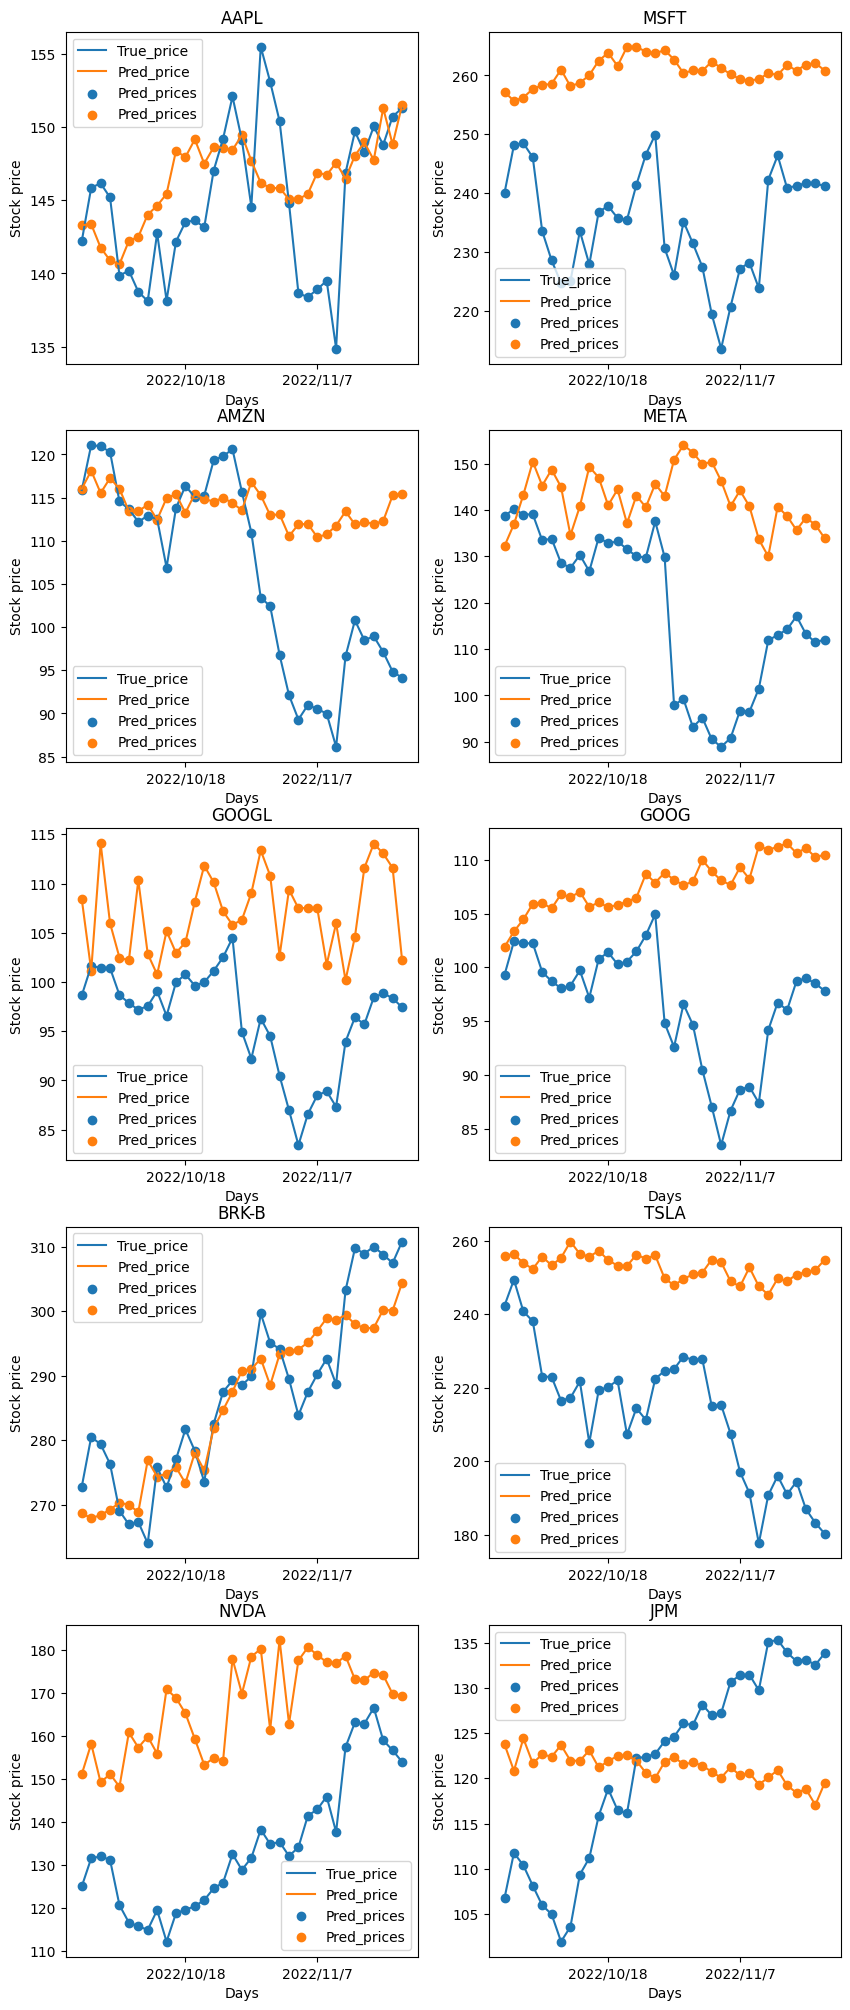

In [52]:
##Visualize the comparison of predicted values against the real values. 
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
week_locator = mdates.WeekdayLocator(byweekday=MO, interval = 2)
SPY_TOP_10_SYMBOLS = ["AAPL", "MSFT", "AMZN", "META", "GOOGL", "GOOG", "BRK-B", "TSLA", "NVDA", "JPM"]

fig = plt.figure(figsize=(10, 25))
for i in range(10):
    fig = plt.subplot(5,2,i+1)
    fig.xaxis.set_major_locator(week_locator)
    df = plotdata.loc[(plotdata['SYMBOL'] == SPY_TOP_10_SYMBOLS[i])]
    #print(df)
    plt.plot(df['True_prices'], label = "True_price")
    plt.plot(df['Pred_prices'], label = "Pred_price")
    plt.scatter(df['Pred_days'], df['True_prices'], label = "Pred_prices")
    plt.scatter(df['Pred_days'], df['Pred_prices'], label = "Pred_prices")
    plt.xlabel("Days")
    plt.ylabel("Stock price")
    plt.legend(loc=0)
    plt.title(SPY_TOP_10_SYMBOLS[i])


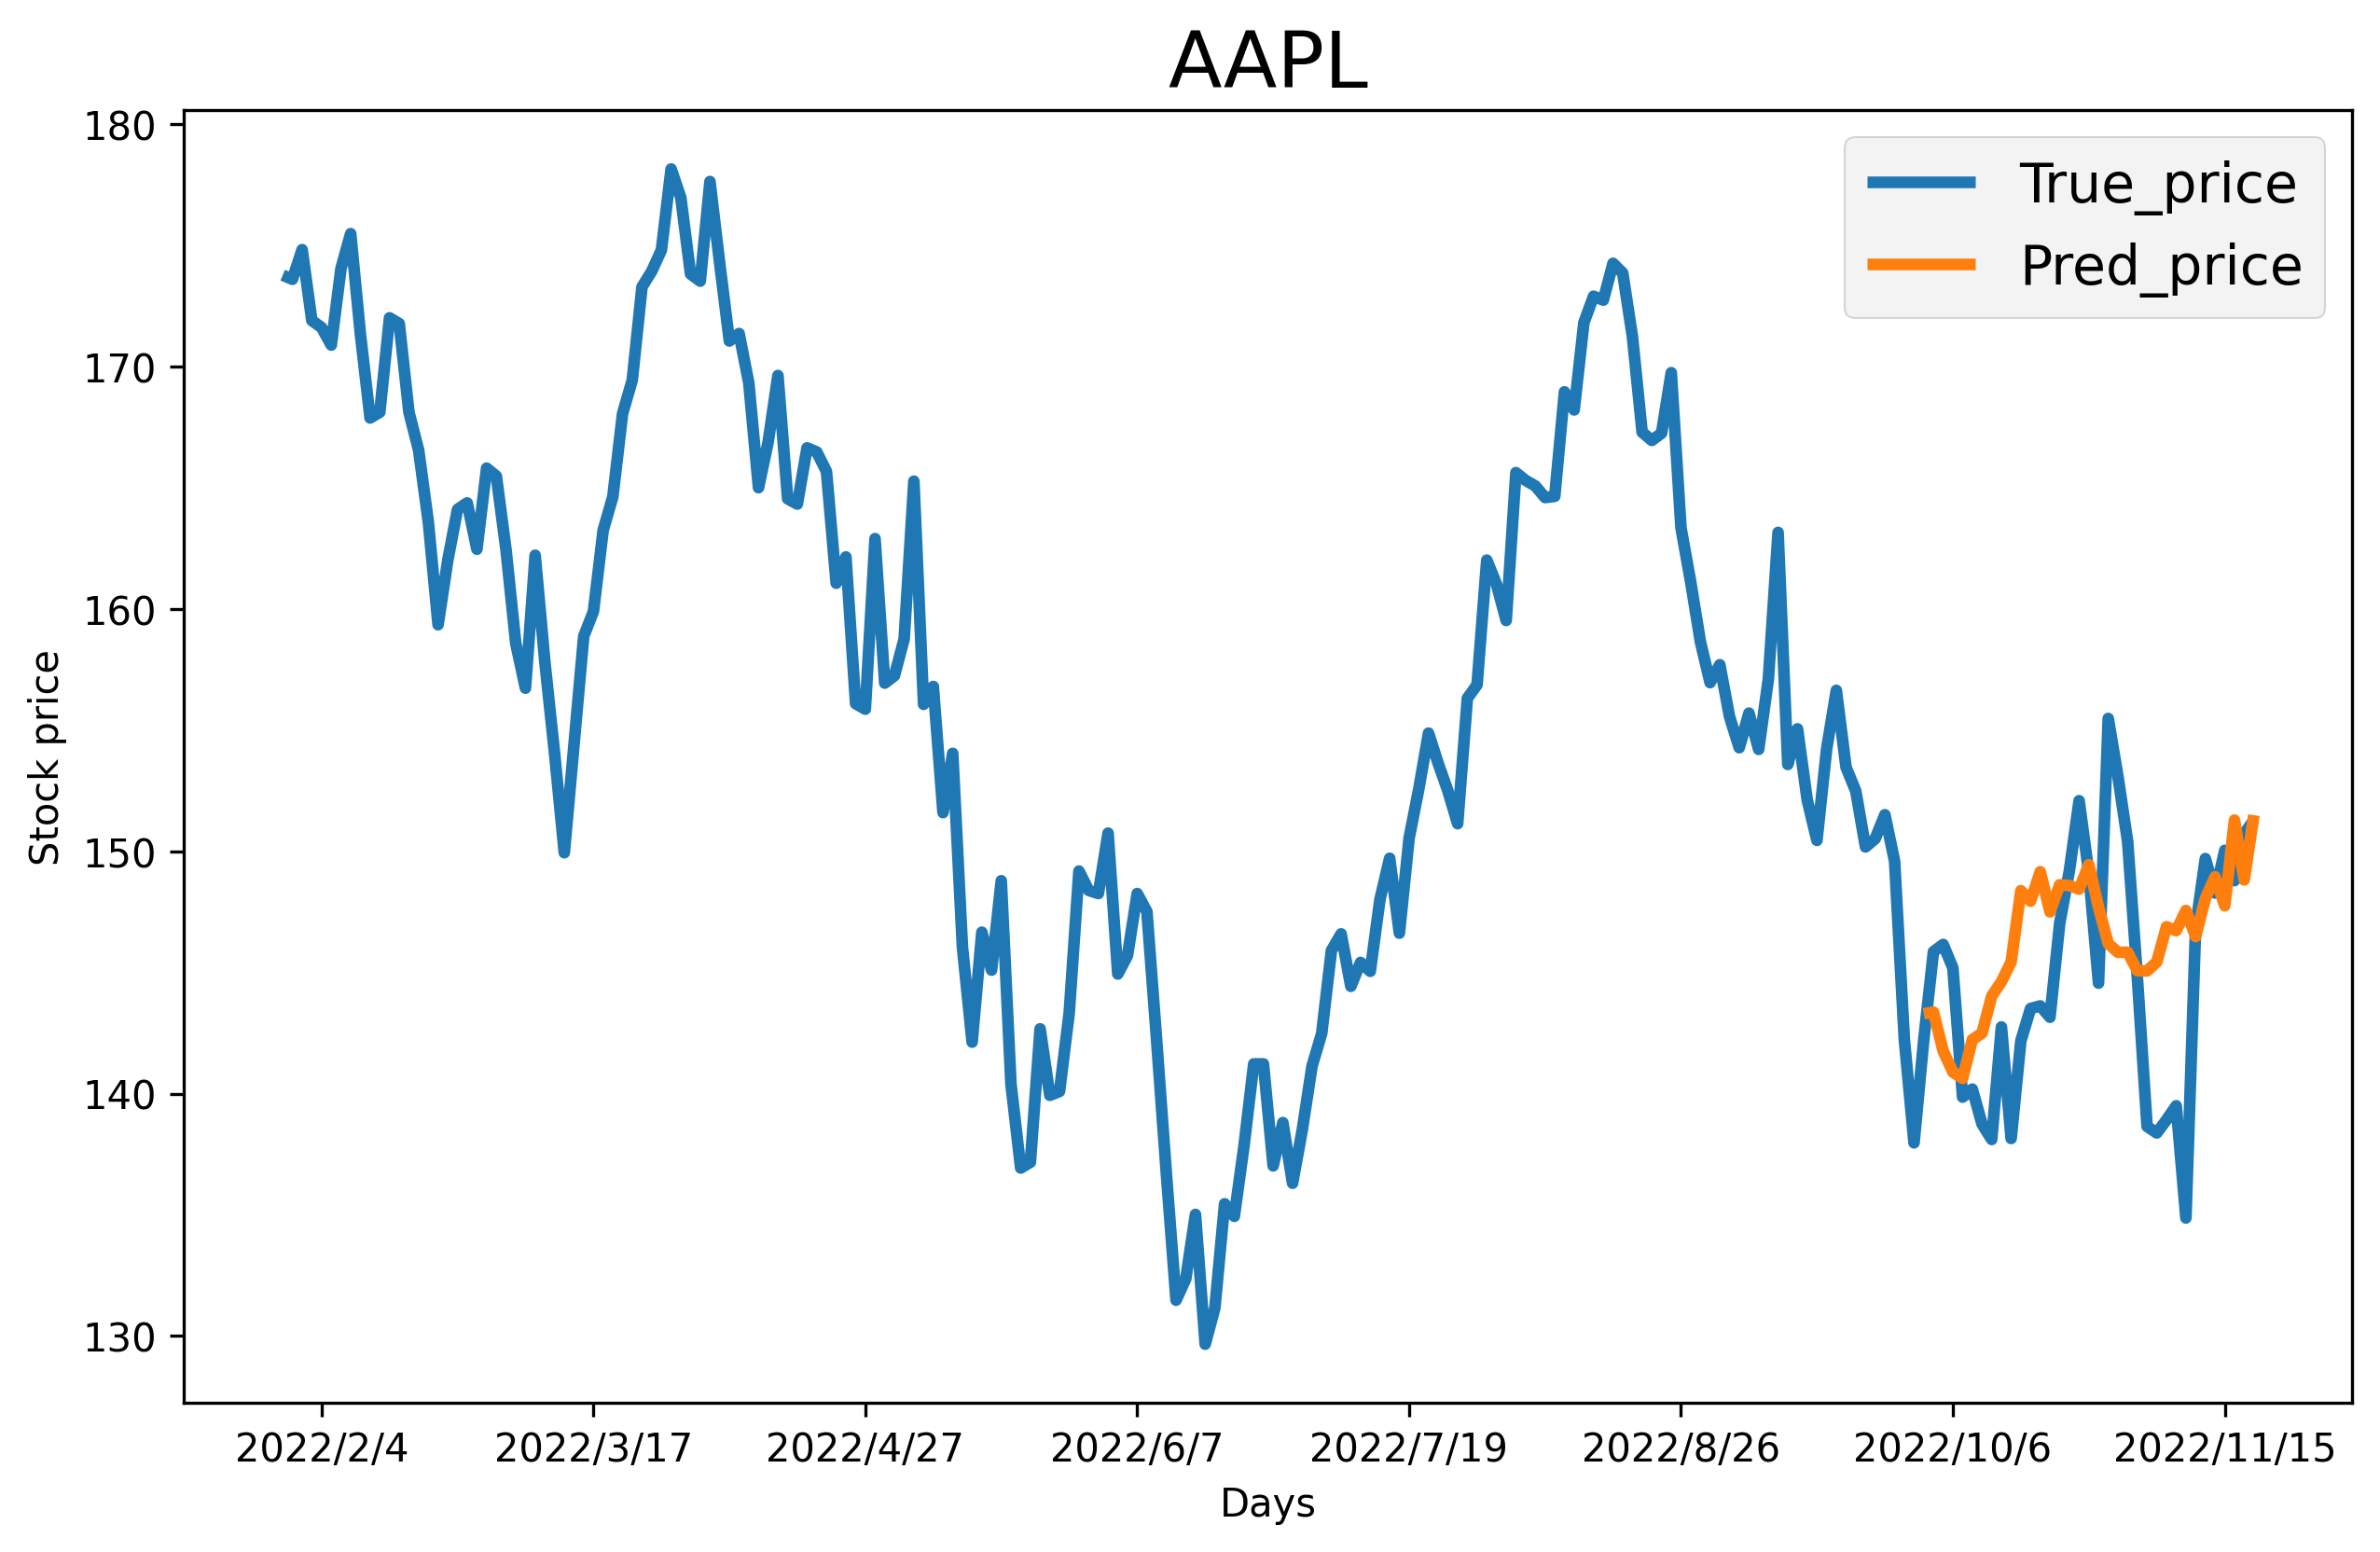

In [56]:
##Visualize the comparison of predicted values against the real values. 
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
week_locator = mdates.WeekdayLocator(byweekday=MO, interval = 4)


Target_SYMBOL = "AAPL"
fig = plt.figure(figsize=(10, 6), dpi = 300)
fig = plt.subplot(1,1,1)
fig.xaxis.set_major_locator(week_locator)

data = pd.read_csv('data.csv')
Actual = data.loc[data['symbol'] == Target_SYMBOL]
Prediction = plotdata.loc[(plotdata['SYMBOL'] == Target_SYMBOL)]
plt.style.use('fivethirtyeight')
plt.plot(Actual['date'], Actual['price'], linewidth = 3,  label = "True_price")
plt.plot(Prediction['Pred_prices'], linewidth = 3, label = "Pred_price")
plt.xlabel("Days")
plt.ylabel("Stock price")
plt.legend(loc=0)
plt.title("AAPL")
plt.savefig("AAPL.png")

In [47]:
##Get a model to assess the MSE, RMSE and MAE for the model prediction (Model prediction error table).
SPY_TOP_10_SYMBOLS = ["AAPL", "MSFT", "AMZN", "META", "GOOGL", "GOOG", "BRK-B", "TSLA", "NVDA", "JPM"]
df_result = pd.read_excel("df_result2.xlsx")
best_result = df_result.sort_values('RMSE').drop_duplicates('SYMBOL').sort_values('SYMBOL')
best_result['SYMBOL'] = pd.Categorical(best_result['SYMBOL'], SPY_TOP_10_SYMBOLS)
best_result.to_excel("Final_Result.xlsx")
#print(best_result)